In [76]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image

from keras import Model
from keras import datasets
from keras.ops import expand_dims
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import Sequential, Input, layers, optimizers
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 01 - MNIST Classfication

## (1) The MNIST Dataset

In [ ]:
# Loading the MNIST Dataset...
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data(path="mnist.npz")

# The train set contains 60 000 images, each of them of size 28x28
# The test set contains 10 000 images, each of them of size 28x28
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(((60000, 28, 28), (60000,)), ((10000, 28, 28), (10000,)))

### (1.1) Exploring the dataset

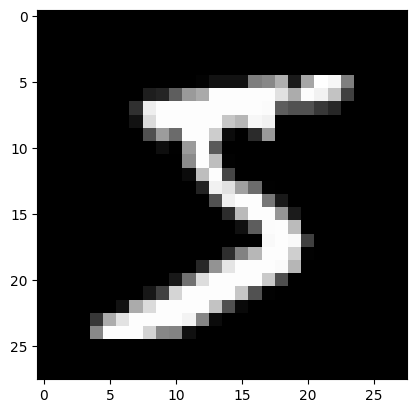

In [ ]:
plt.imshow(X_train[0], cmap='gray')
plt.show()

### (1.2) Image Preprocessing

In [ ]:
X_train = X_train / 255.
X_test = X_test / 255.

### (1.3) Inputs' dimensionality

In [ ]:
print(X_train.shape)
print(X_test.shape)

# The shape of tensors fed into CNNs in the following: (NUMBER_OF_IMAGES, HEIGHT, WIDTH, CHANNELS)
X_train = expand_dims(X_train, axis=-1)
X_test = expand_dims(X_test, axis=-1)

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


### (1.4) Target encoding

In [ ]:
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# Quick check that you correctly used to_categorical
assert(y_train_cat.shape == (60000,10))
assert(y_test_cat.shape == (10000,10))

## (2) The CNN

### (2.1) Architecture and compilation of a CNN

In [ ]:
def init_compile_model():
  model = Sequential()
  model.add(Input(shape=(28, 28, 1)))

  model.add(layers.Conv2D(8, (4, 4), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model = init_compile_model()
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_47 (Conv2D)              │ (None, 28, 28, 8)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 10)             │         7,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,264 (36.19 KB)

 Trainable params: 9,264 (36.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# First Conv2D
first_layer_weights = 8 * (4*4) * 1 + 8

# Second Conv2D
second_layer_weights = 16 * (3*3) * 8 + 16

# Third Conv2D
third_layer_weights = 10 * 7 * 7 * 16 + 10

# Dense Layer
dense_layer_weights = 10 * 10 + 10

total_number_of_weights = first_layer_weights + second_layer_weights + third_layer_weights + dense_layer_weights
total_number_of_weights

9264

### (2.2) Training a CNN

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train_cat,
    validation_split=0.3,
    epochs=5,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.6904 - loss: 0.9139 - val_accuracy: 0.9426 - val_loss: 0.1947
Epoch 2/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9490 - loss: 0.1678 - val_accuracy: 0.9601 - val_loss: 0.1313
Epoch 3/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9682 - loss: 0.1070 - val_accuracy: 0.9694 - val_loss: 0.1015
Epoch 4/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9748 - loss: 0.0823 - val_accuracy: 0.9752 - val_loss: 0.0781
Epoch 5/5
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9798 - loss: 0.0632 - val_accuracy: 0.9804 - val_loss: 0.0659


### (2.3) Evaluating its performance

In [ ]:
res = model.evaluate(X_test, y_test_cat, verbose=1)
print(f'The accuracy on the test set is of {res[1]*100:.2f} %')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9801 - loss: 0.0629
The accuracy on the test set is of 98.30 %


# 02 - Intuition on Convolutions

## (0) The dataset

In [ ]:
!wget https://wagon-public-datasets.s3.amazonaws.com/06-DL/03-Convolutional-Neural-Networks/deep-learning-circles-triangles/circles-and-triangles.zip
!unzip -qn circles-and-triangles.zip

--2025-10-09 16:40:29--  https://wagon-public-datasets.s3.amazonaws.com/06-DL/03-Convolutional-Neural-Networks/deep-learning-circles-triangles/circles-and-triangles.zip
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 52.92.0.89, 3.5.69.100, 52.218.90.42, ...
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|52.92.0.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 186323 (182K) [application/zip]
Saving to: ‘circles-and-triangles.zip’

circles-and-triangl 100%[===================>] 181.96K   634KB/s    in 0.3s    

2025-10-09 16:40:30 (634 KB/s) - ‘circles-and-triangles.zip’ saved [186323/186323]



In [ ]:
def load_data(path):
  nb_circles = 100
  nb_triangles = 100

  X, y = [], []

  for i in range(nb_circles):
    c_path = os.path.join(path, 'circles', f'circle_{i}.png')
    X.append(np.array(Image.open(c_path))[:, :, :1])
    y.append(0)

  for i in range(nb_triangles):
    t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
    X.append(np.array(Image.open(t_path))[:, :, :1])
    y.append(1)

  c = list(zip(X, y))
  np.random.shuffle(c)
  X, y = zip(*c)

  return np.array(X), np.array(y)

X, y = load_data('data')

In [ ]:
X.shape

(200, 76, 78, 1)

In [ ]:
# The data are between 0 and 255.
np.min(X), np.max(X)

(np.uint8(0), np.uint8(255))

In [ ]:
X = X / 255

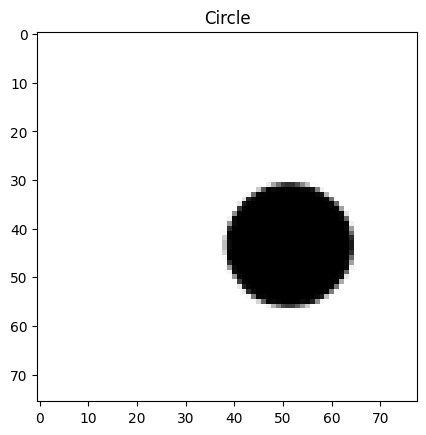

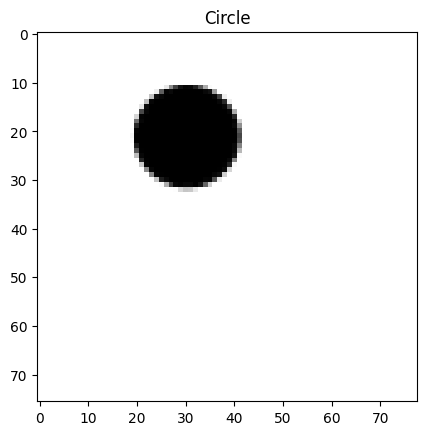

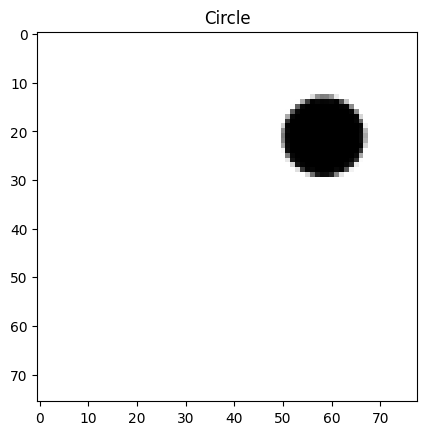

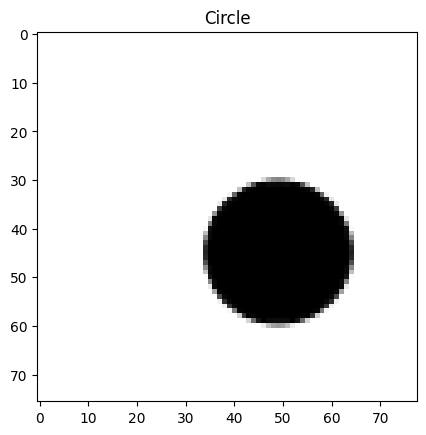

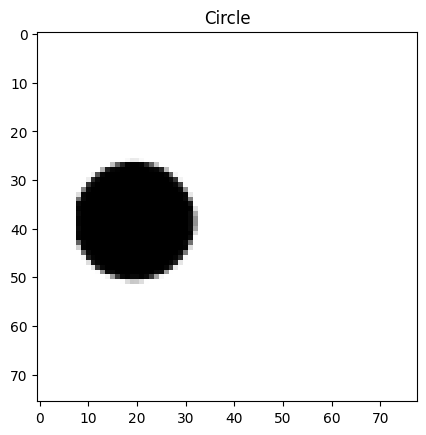

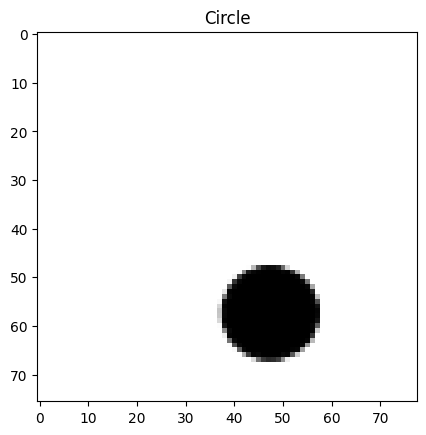

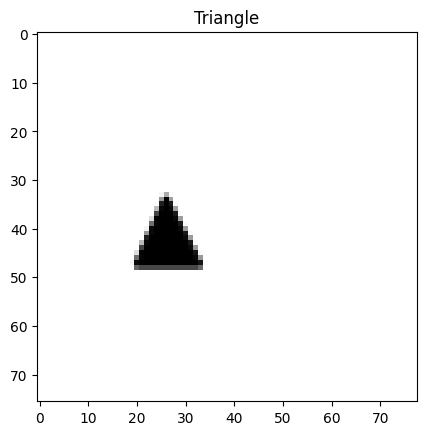

In [ ]:
for iter_, (image, label) in enumerate(zip(X, y)):
  plt.imshow(image[:, :, 0], cmap='gray')
  plt.title('Triangle' if label == 1 else 'Circle')
  plt.show()

  if iter_ > 5:
    break

In [ ]:
np.unique(y, return_counts=True) # -> Two categories to predict

(array([0, 1]), array([100, 100]))

## (1) Kernels & Convolution

In [ ]:
def compute_convolution(input_image, kernel):
  # Parameters
  kernel = np.array(kernel)
  kernel_height, kernel_width = kernel.shape

  img = np.squeeze(input_image) # Removes dimensions of size 1
  img_height, img_width = img.shape

  output_image = []

  for x in range(img_height - kernel_height + 1):
    arr = []

    for y in range(img_width - kernel_width + 1):
      a = np.multiply(img[x: x + kernel_height, y: y + kernel_width], kernel)
      arr.append(a.sum())

    output_image.append(arr)

  return output_image

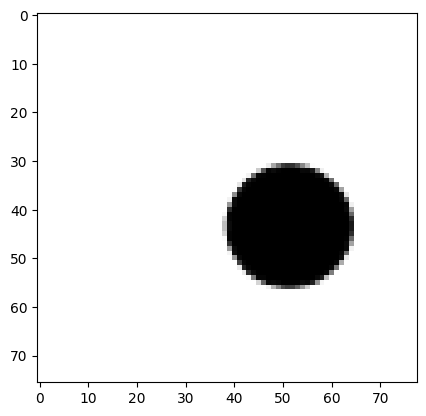

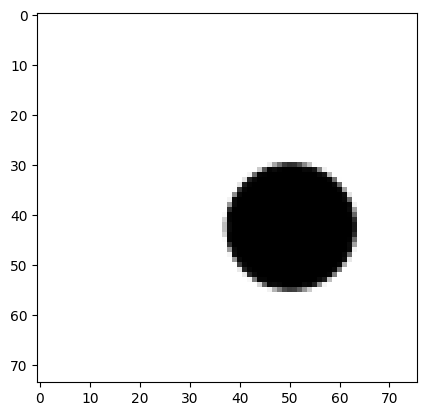

In [ ]:
identity_kernel = [
  [0, 0, 0],
  [0, 1, 0],
  [0, 0, 0]
]

input_image = X[0]
kernel = identity_kernel

output_image = compute_convolution(input_image, kernel)

# Original Image
plt.imshow(np.squeeze(X[0]), cmap='gray')
plt.show()

# Convoluted image
plt.imshow(output_image, cmap='gray')
plt.show()

In [ ]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''

    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)

    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')

    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')

    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

    plt.show()

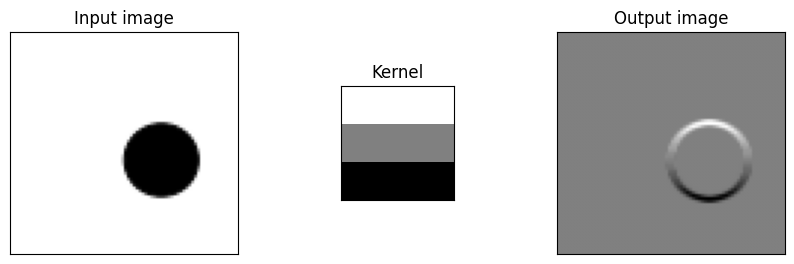

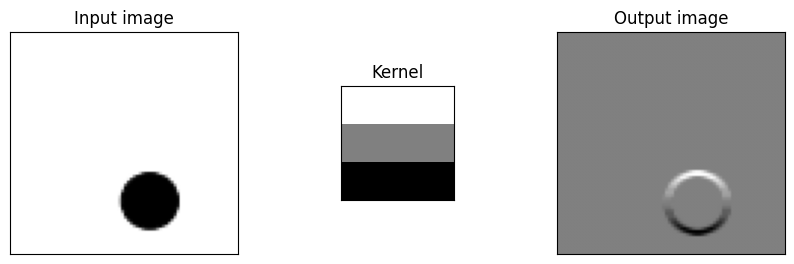

In [ ]:
kernel_1 = [
  [1, 1, 1],
  [0, 0, 0],
  [-1, -1, -1]
]
plot_convolution(X[0], kernel_1)
plot_convolution(X[5], kernel_1)

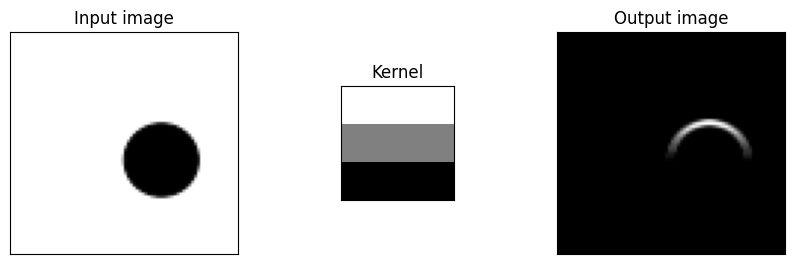

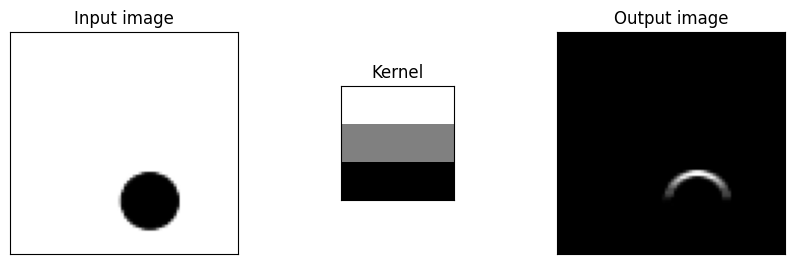

In [ ]:
plot_convolution(X[0], kernel_1, True)
plot_convolution(X[5], kernel_1, True)

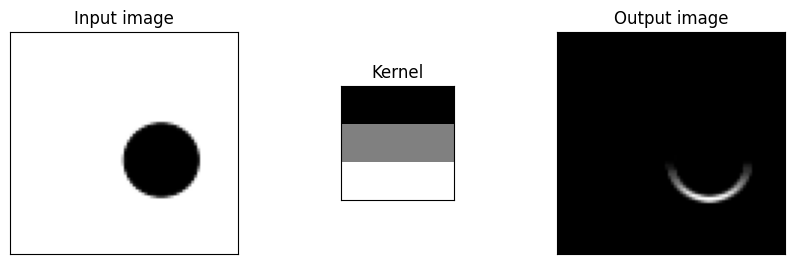

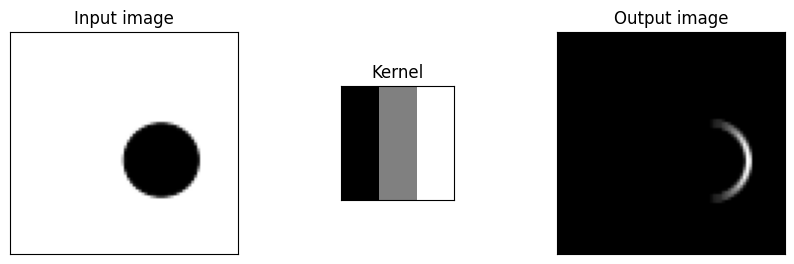

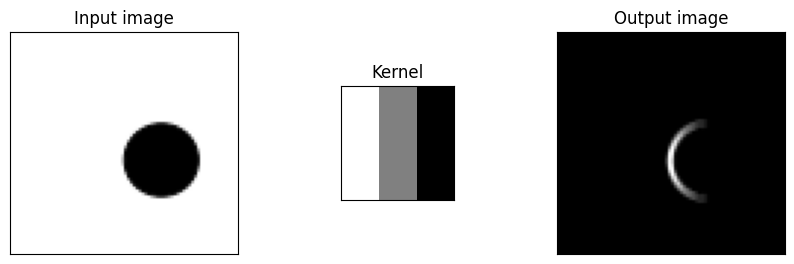

In [ ]:
kernel_2 = [
  [-1, -1, -1],
  [0, 0, 0],
  [1, 1, 1],
]

kernel_3 = [
  [-1, 0, 1],
  [-1, 0, 1],
  [-1, 0, 1]
]

kernel_4 = [
  [1, 0, -1],
  [1, 0, -1],
  [1, 0, -1]
]

plot_convolution(X[0], kernel_2, activation=True)
plot_convolution(X[0], kernel_3, activation=True)
plot_convolution(X[0], kernel_4, activation=True)

In [ ]:
kernel_big = np.array([
    np.ones((10,)),
    np.ones((10,)),
    np.ones((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.ones((10,))*-1,
    np.ones((10,))*-1,
    np.ones((10,))*-1,
])

kernel_big

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

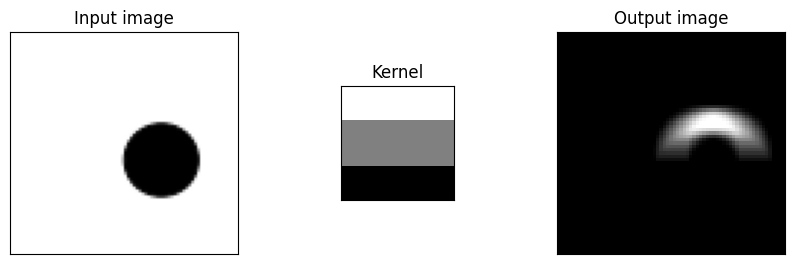

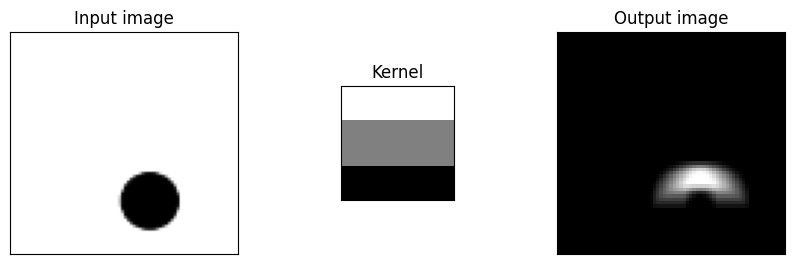

In [ ]:
plot_convolution(X[0], kernel_big, activation=True)
plot_convolution(X[5], kernel_big, activation=True)

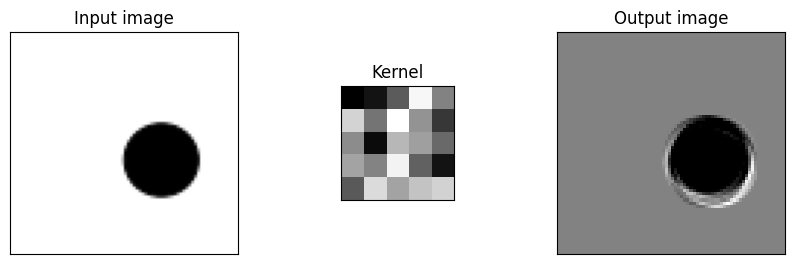

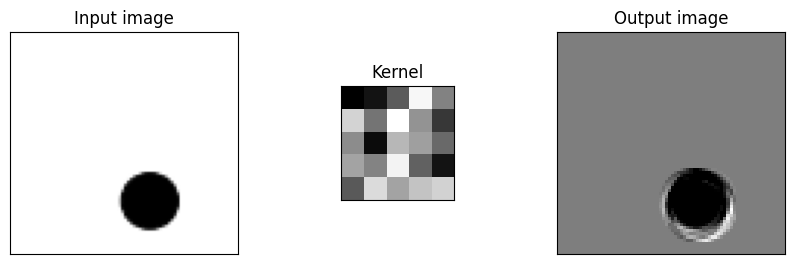

In [ ]:
random_kernel = np.random.uniform(-10, 10, (5, 5))

plot_convolution(X[0], random_kernel, activation=True)
plot_convolution(X[5], random_kernel, activation=True)

## (2) Training a CNN to detect triangles and circles

### (2.1) Architecture

In [ ]:
X.shape

(200, 76, 78, 1)

In [ ]:
def init_compile_model():
  model = Sequential()
  model.add(Input(shape=(76, 78, 1)))

  model.add(layers.Conv2D(16, (4, 4), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Conv2D(64, (2, 2), activation='relu'))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

### (2.2) Training

In [ ]:
model = init_compile_model()
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 73, 75, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 36, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 34, 35, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 6, 6, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │         5,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,637 (178.27 KB)

 Trainable params: 45,637 (178.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X, y, validation_split=0.3, batch_size=16, epochs=50, callbacks=[es], verbose=1)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.4939 - loss: 0.6913 - val_accuracy: 0.5000 - val_loss: 0.6740
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6424 - loss: 0.6697 - val_accuracy: 0.5000 - val_loss: 0.6470
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5992 - loss: 0.6202 - val_accuracy: 0.8000 - val_loss: 0.5625
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7754 - loss: 0.5188 - val_accuracy: 0.8833 - val_loss: 0.4511
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9412 - loss: 0.3741 - val_accuracy: 0.9167 - val_loss: 0.2646
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9400 - loss: 0.2182 - val_accuracy: 0.9000 - val_loss: 0.2276
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8875 - loss: 0.2153 - val_accuracy: 0.9000 - val_loss: 0.2271
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9245 - loss: 0.1549 - val_accuracy: 0.9500 - val_loss: 0.1228

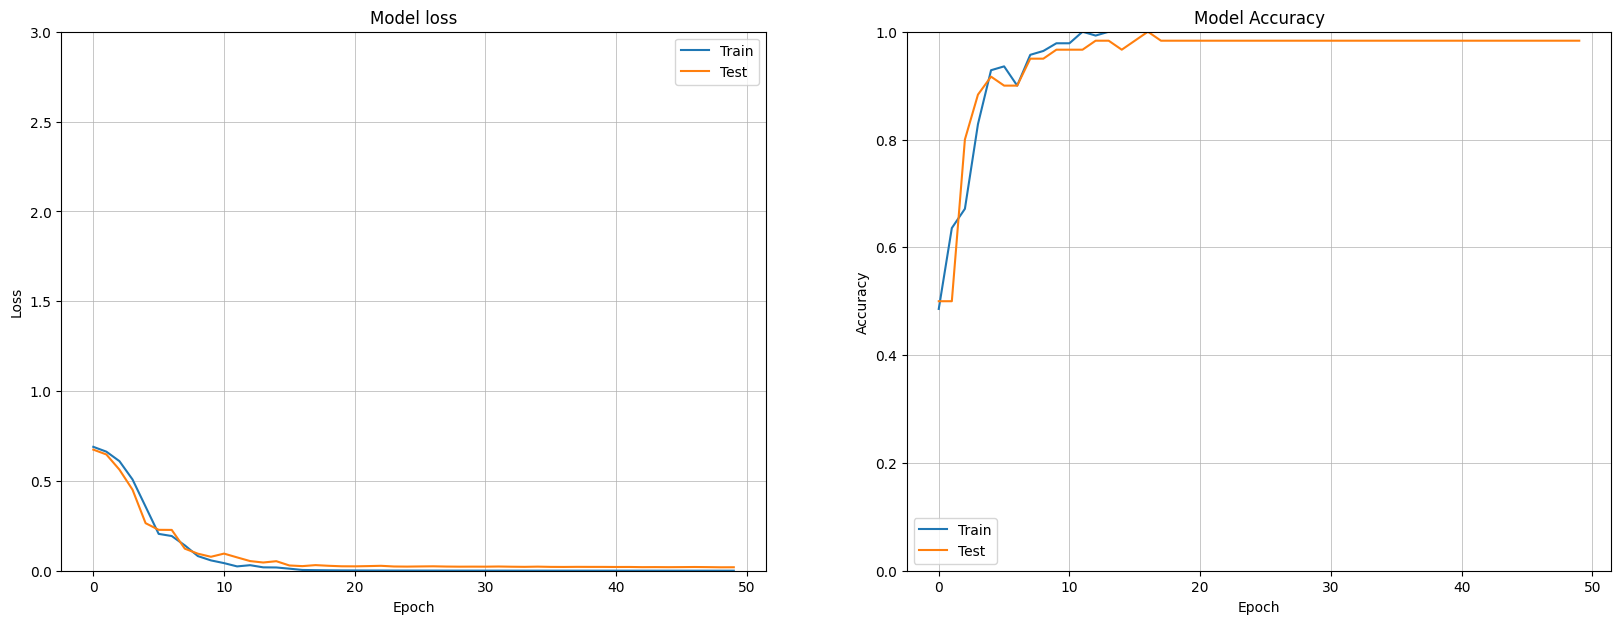

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

plot_loss_accuracy(history)

### (2.3) Deeper understanding of CNNs

In [ ]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 73, 75, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 36, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 34, 35, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 6, 6, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │         5,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,913 (534.82 KB)

 Trainable params: 45,637 (178.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,276 (356.55 KB)

In [ ]:
model.layers

[<Conv2D name=conv2d_49, built=True>,
 <MaxPooling2D name=max_pooling2d_48, built=True>,
 <Conv2D name=conv2d_50, built=True>,
 <MaxPooling2D name=max_pooling2d_49, built=True>,
 <Conv2D name=conv2d_51, built=True>,
 <MaxPooling2D name=max_pooling2d_50, built=True>,
 <Conv2D name=conv2d_52, built=True>,
 <MaxPooling2D name=max_pooling2d_51, built=True>,
 <Flatten name=flatten_24, built=True>,
 <Dense name=dense_48, built=True>,
 <Dense name=dense_49, built=True>]

#### (2.3.1) Kernels

In [ ]:
# Accessing the first convolutional layer of the CNN
first_convolutional_layer = model.layers[0]
first_convolutional_layer

<Conv2D name=conv2d_49, built=True>

In [ ]:
# Weights of the first convolutional layer of the CNN - which was trained/optimized
first_convolutional_layer.weights[0].shape

TensorShape([4, 4, 1, 16])

In [ ]:
# Biases of the first convolutional layer of the CNN - which was trained/optimized
first_convolutional_layer.weights[1].shape

TensorShape([16])

In [ ]:
# Notice that we have indeed 256 weights + 16 biases = 272 parameters for the first convolutional layer
4*4*1*16+16

272

In [ ]:
# Accessing the second convolutional layer of the CNN
second_convolutional_layer = model.layers[2]
second_convolutional_layer

<Conv2D name=conv2d_50, built=True>

In [ ]:
# Weights of the second convolutional layer of the CNN - which was trained/optimized
second_convolutional_layer.weights[0].shape

TensorShape([3, 3, 16, 32])

In [ ]:
# Weights of the second convolutional layer of the CNN - which was trained/optimized
second_convolutional_layer.weights[0].shape

TensorShape([3, 3, 16, 32])

In [ ]:
# Notice that we have indeed 4608 weights + 32 biases = 4640 parameters for the third convolutional layer
3*3*16*32+32

4640

In [ ]:
# Accessing the third convolutional layer of the CNN
third_convolutional_layer = model.layers[4]
third_convolutional_layer

<Conv2D name=conv2d_51, built=True>

In [ ]:
# Weights of the third convolutional layer of the CNN - which was trained/optimized
third_convolutional_layer.weights[0].shape

TensorShape([3, 3, 32, 64])

In [ ]:
# Biases of the third convolutional layer of the CNN - which was trained/optimized
third_convolutional_layer.weights[1].shape

TensorShape([64])

In [ ]:
# Notice that we have indeed 18432 weights + 64 biases = 18496 parameters for the fourth convolutional layer
3*3*32*64+64

18496

In [ ]:
# Accessing the fourth convolutional layer of the CNN
fourth_convolutional_layer = model.layers[6]
fourth_convolutional_layer

<Conv2D name=conv2d_52, built=True>

In [ ]:
# Weights of the fourth convolutional layer of the CNN - which was trained/optimized
fourth_convolutional_layer.weights[0].shape

TensorShape([2, 2, 64, 64])

In [ ]:
# Biases of the fourth convolutional layer of the CNN - which was trained/optimized
fourth_convolutional_layer.weights[1].shape

TensorShape([64])

In [ ]:
# Notice that we have indeed 16384 weights + 64 biases = 16448 parameters for the fourth convolutional layer
(2*2*64+1)*64

16448

------------------------- Effect of the kernel number 0 -------------------------


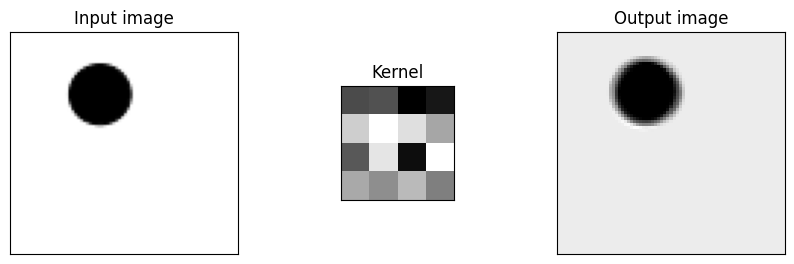

------------------------- Effect of the kernel number 1 -------------------------


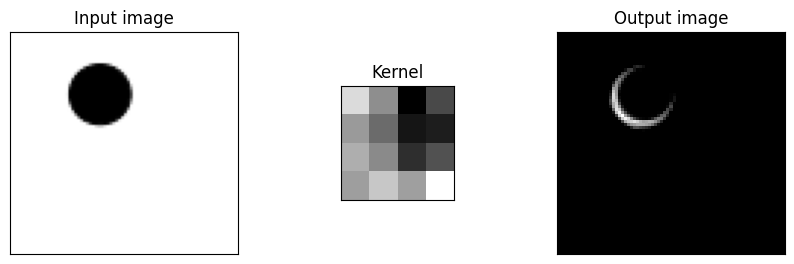

------------------------- Effect of the kernel number 2 -------------------------


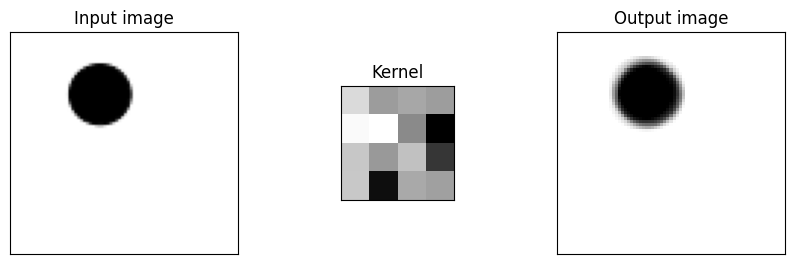

------------------------- Effect of the kernel number 3 -------------------------


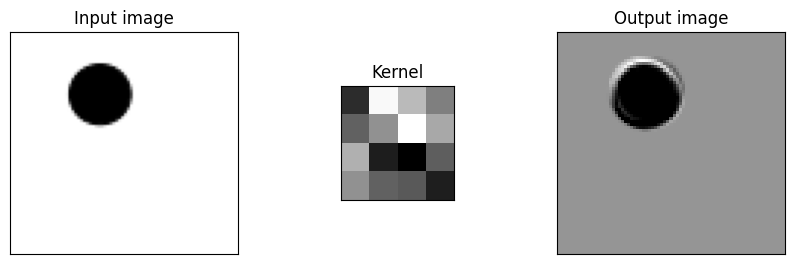

------------------------- Effect of the kernel number 4 -------------------------


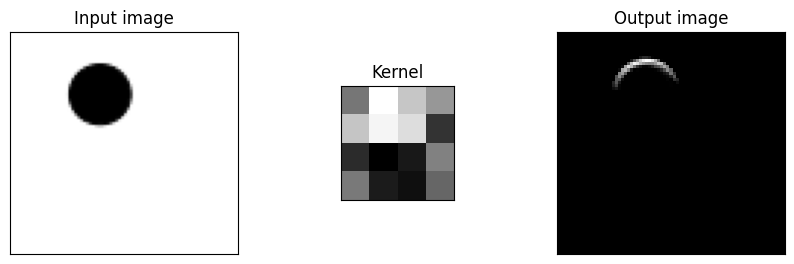

------------------------- Effect of the kernel number 5 -------------------------


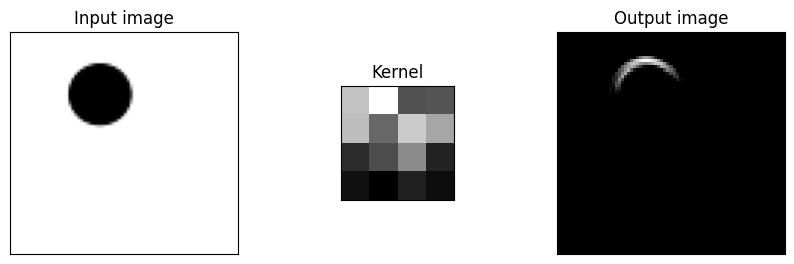

------------------------- Effect of the kernel number 6 -------------------------


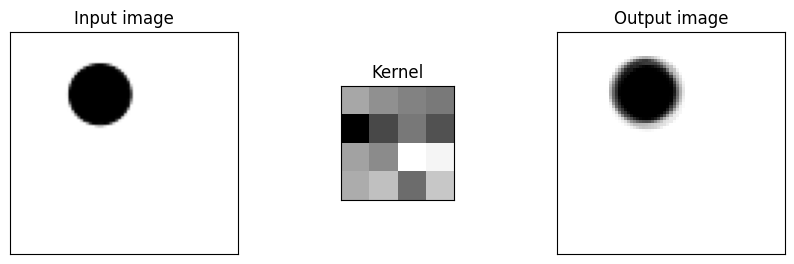

------------------------- Effect of the kernel number 7 -------------------------


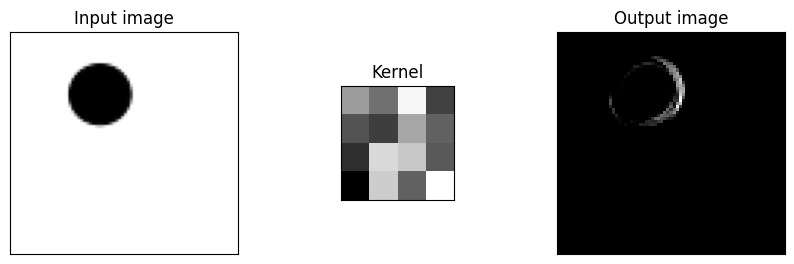

------------------------- Effect of the kernel number 8 -------------------------


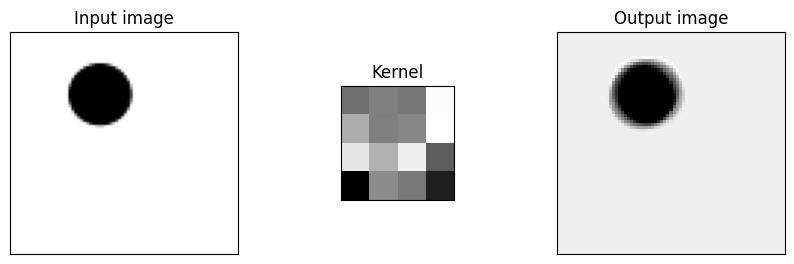

------------------------- Effect of the kernel number 9 -------------------------


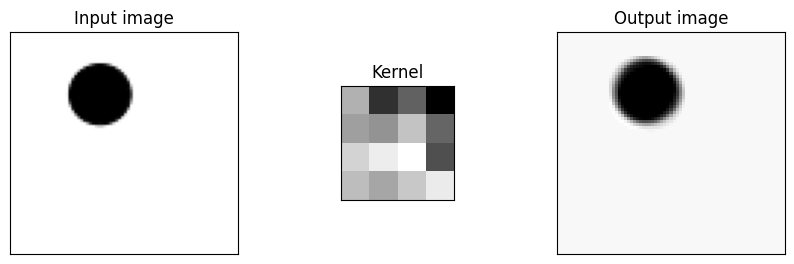

------------------------- Effect of the kernel number 10 -------------------------


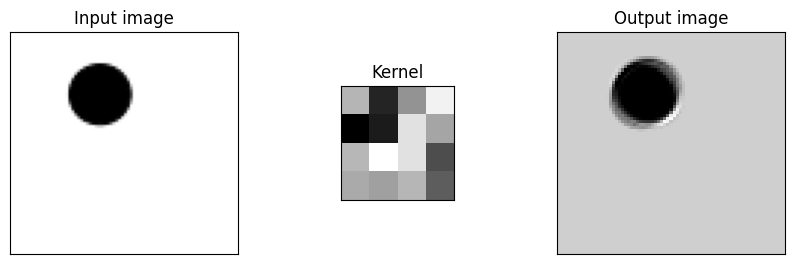

------------------------- Effect of the kernel number 11 -------------------------


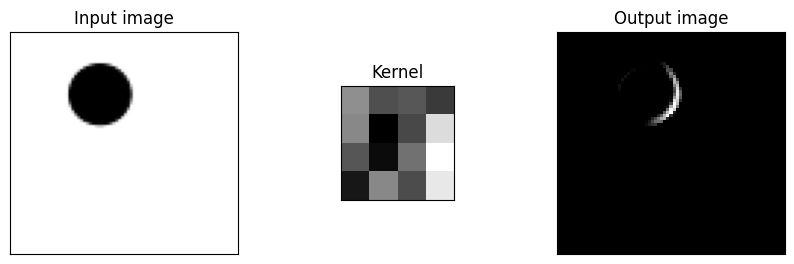

------------------------- Effect of the kernel number 12 -------------------------


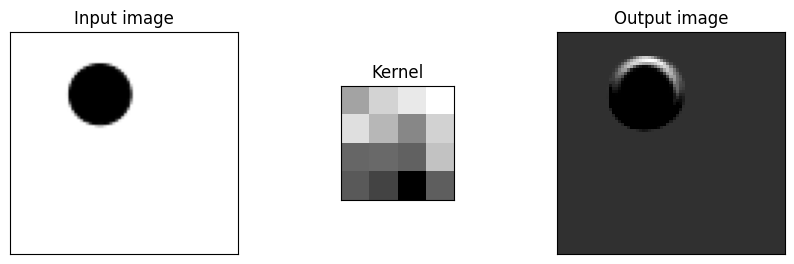

------------------------- Effect of the kernel number 13 -------------------------


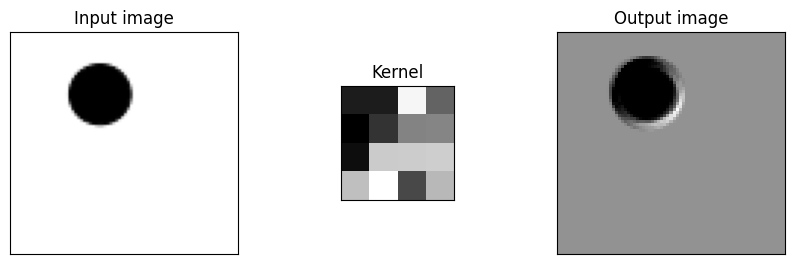

------------------------- Effect of the kernel number 14 -------------------------


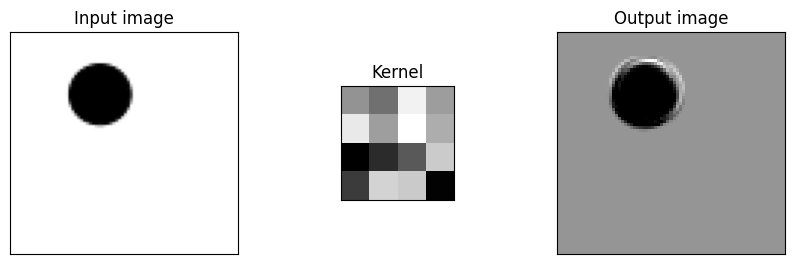

------------------------- Effect of the kernel number 15 -------------------------


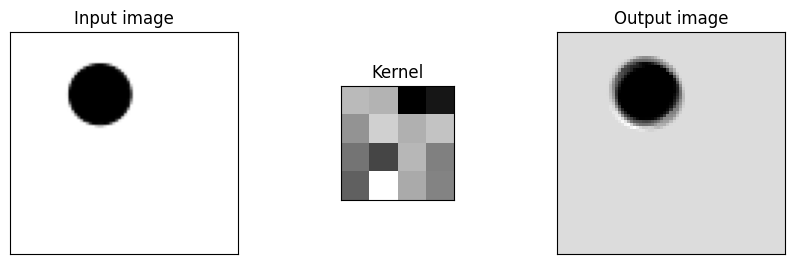

In [ ]:
# First Convolutional Neural Network
layer_number = 0

# The input image has only 1 channel - Black&White picture
channel_number = 0

# Analyzing the impact of all the 16 kernels of the first convolutional layer
for k in np.arange(0, 16):
  print(f"------------------------- Effect of the kernel number {k} -------------------------")
  kernel = model.layers[layer_number].weights[0].numpy()[:, :, channel_number, k]
  plot_convolution(X[1], kernel, activation=True)

#### (2.3.2) Activations

In [ ]:
# Step 0 - Reminders of the CNN's summary
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_49 (Conv2D)              │ (None, 73, 75, 16)     │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 36, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 34, 35, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 6, 6, 64)       │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │         5,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,913 (534.82 KB)

 Trainable params: 45,637 (178.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 91,276 (356.55 KB)

In [ ]:
# Step 1 - Listing all the 11 layers' outputs of your CNN
layers_outputs = [layer.output for layer in model.layers]
layers_outputs

[<KerasTensor shape=(None, 73, 75, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_700>,
 <KerasTensor shape=(None, 36, 37, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_702>,
 <KerasTensor shape=(None, 34, 35, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_705>,
 <KerasTensor shape=(None, 17, 17, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_709>,
 <KerasTensor shape=(None, 15, 15, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_714>,
 <KerasTensor shape=(None, 7, 7, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_720>,
 <KerasTensor shape=(None, 6, 6, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_727>,
 <KerasTensor shape=(None, 3, 3, 64), dtype=float32, sparse=False, ragged=False, name=keras_tensor_735>,
 <KerasTensor shape=(None, 576), dtype=float32, sparse=False, ragged=False, name=keras_tensor_744>,
 <KerasTensor shape=(None, 10), dtype=float32, spa

In [ ]:
# Step 2 - Instantiate 11 sub-models re-using already trained weights and biases
activation_models = [Model(inputs=model.inputs, outputs=[output]) for output in layers_outputs]

In [ ]:
# Step 3 - Compute the outputs of each submodel
# Some warnings, you can ignore them
activations = [m.predict(X) for m in activation_models]
len(activations)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


11

In [ ]:
layers_outputs = [layer.output for layer in model.layers] # same as above
activation_model = Model(inputs=model.inputs, outputs=layers_outputs) # model with many outputs !
activations = activation_model.predict(X) # 11 predictions at once!
[activation.shape for activation in activations]

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step


[(200, 73, 75, 16),
 (200, 36, 37, 16),
 (200, 34, 35, 32),
 (200, 17, 17, 32),
 (200, 15, 15, 64),
 (200, 7, 7, 64),
 (200, 6, 6, 64),
 (200, 3, 3, 64),
 (200, 576),
 (200, 10),
 (200, 1)]

#### (2.3.3) The final show

--- Observing the effect of the convolutional layer number 0... ---

16 kernels were applied and here are all the activations of this Conv2D Layer:


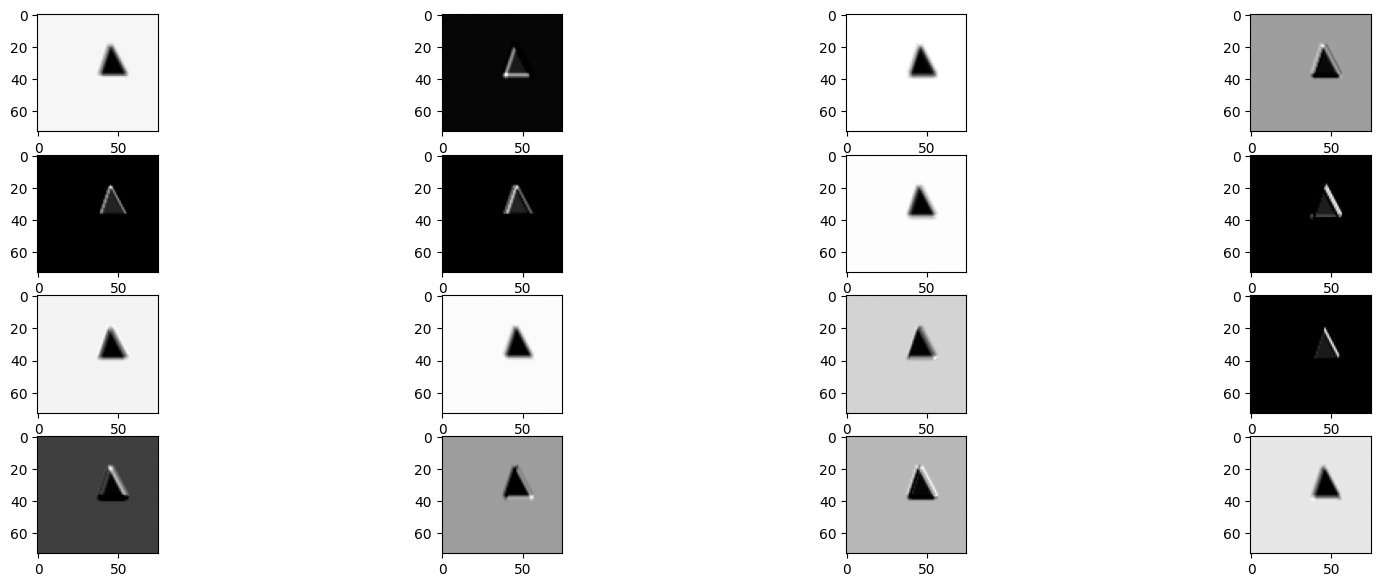

--- Observing the effect of the convolutional layer number 2... ---

32 kernels were applied and here are all the activations of this Conv2D Layer:


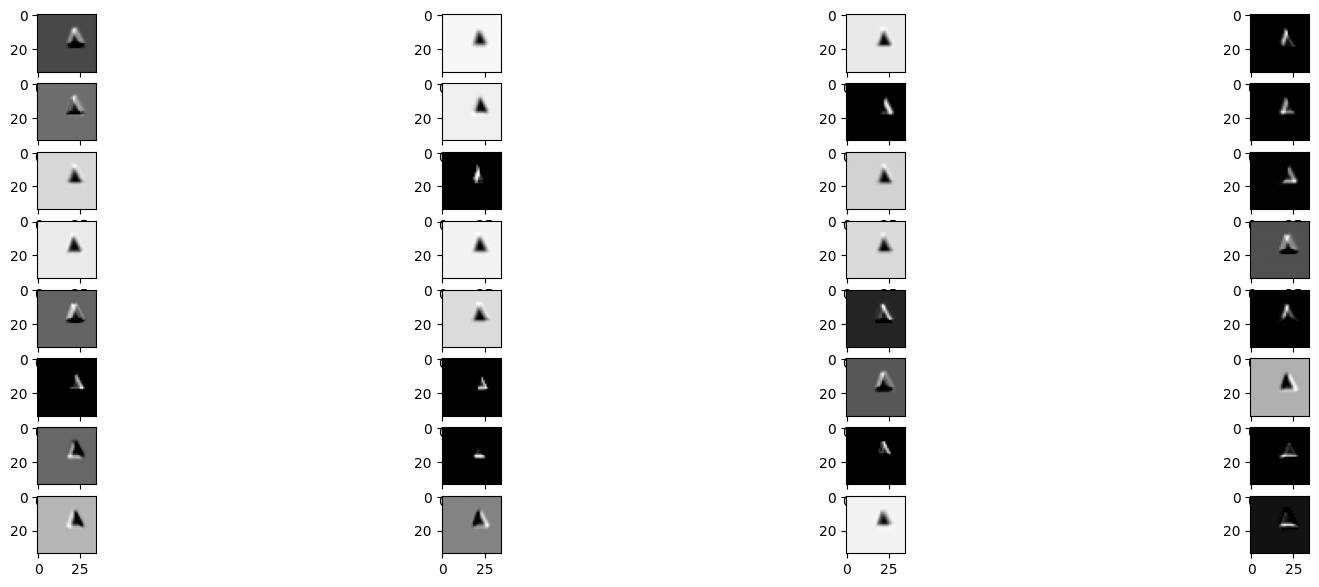

--- Observing the effect of the convolutional layer number 4... ---

64 kernels were applied and here are all the activations of this Conv2D Layer:


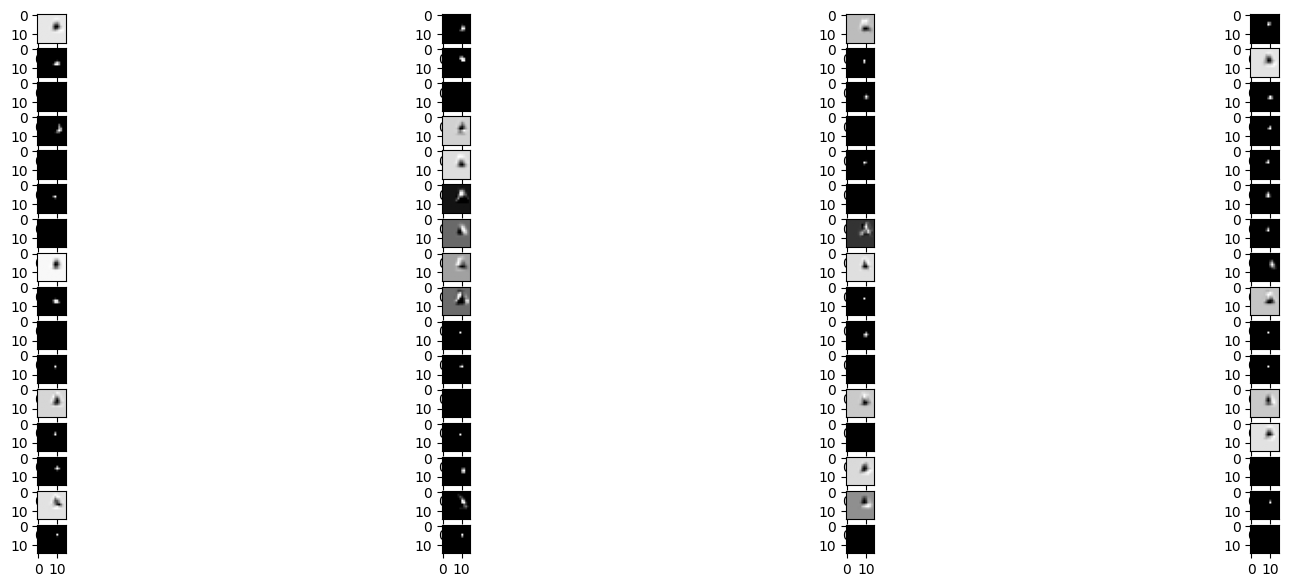

--- Observing the effect of the convolutional layer number 6... ---

64 kernels were applied and here are all the activations of this Conv2D Layer:


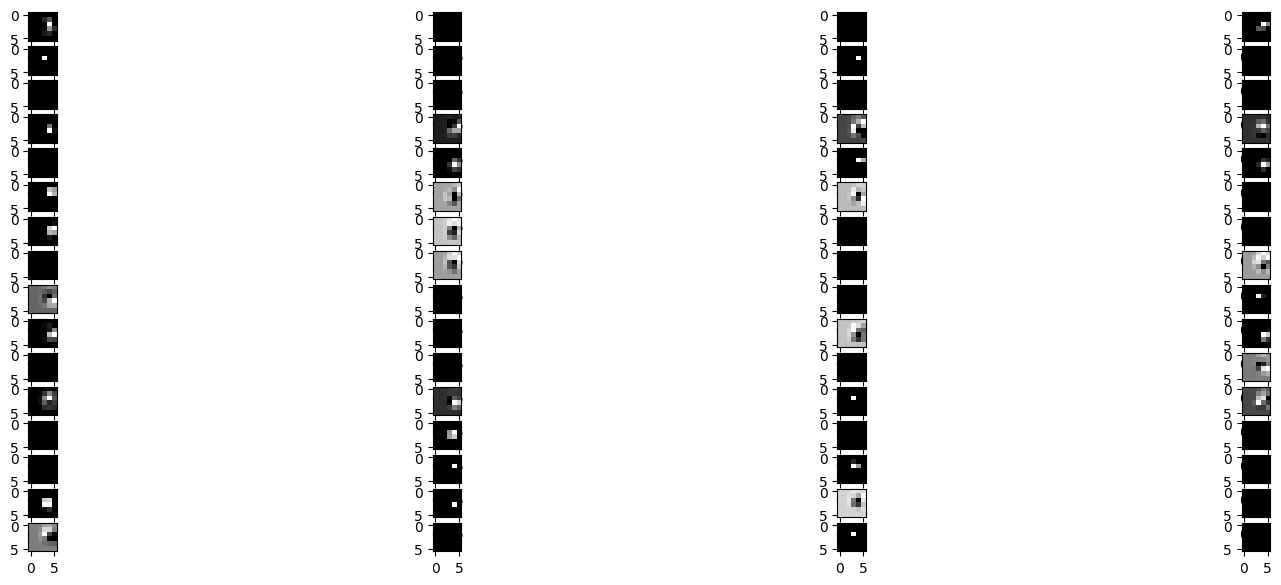

In [ ]:
# Selecting a random triangle
image_number = np.random.choice(np.where(y == 1)[0])

for layer_number in [0,2,4,6]:

    print(f"--- Observing the effect of the convolutional layer number {layer_number}... ---")
    print("")

    temp_number_kernels = model.layers[layer_number].weights[0].shape[-1]
    print(f"{temp_number_kernels} kernels were applied and here are all the activations of this Conv2D Layer:")

    fig, axes = plt.subplots(int(temp_number_kernels/4),4, figsize=(20,7))


    for ax, kernel_number in zip(axes.flat,range(temp_number_kernels)):
        activation = activations[layer_number][image_number][:, :, kernel_number]
        ax.imshow(activation, cmap="gray")

    plt.show()

--- Observing the effect of the convolutional layer number 0... ---

16 kernels were applied and here are all the activations of this Conv2D Layer:


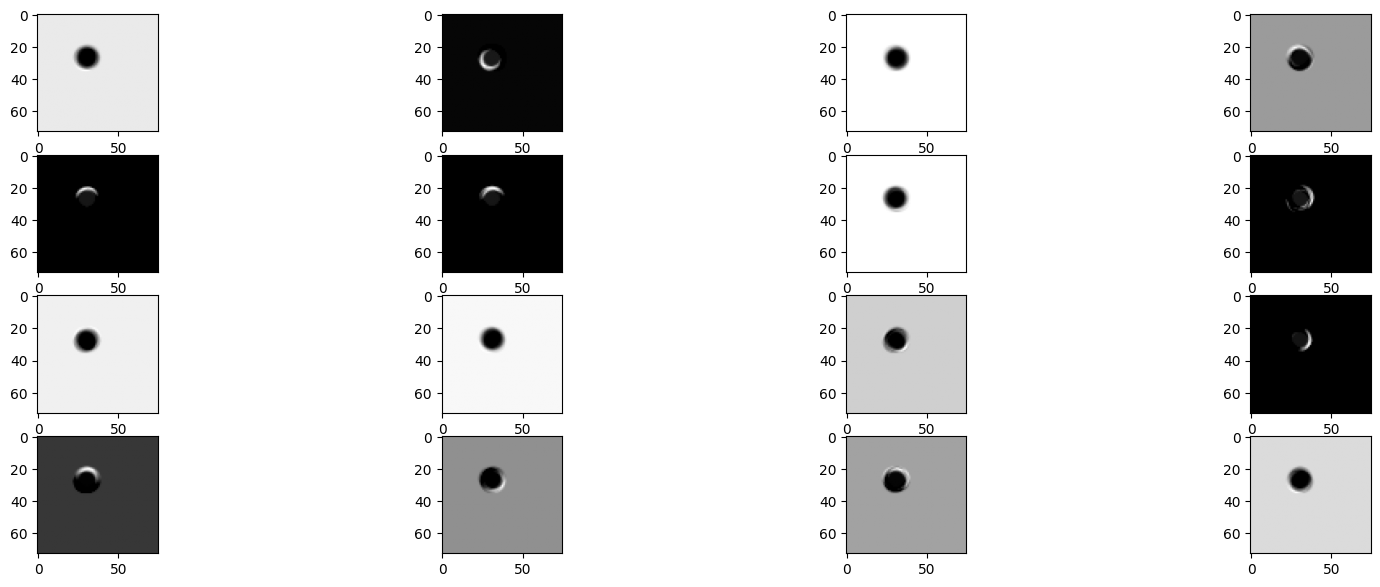

--- Observing the effect of the convolutional layer number 2... ---

32 kernels were applied and here are all the activations of this Conv2D Layer:


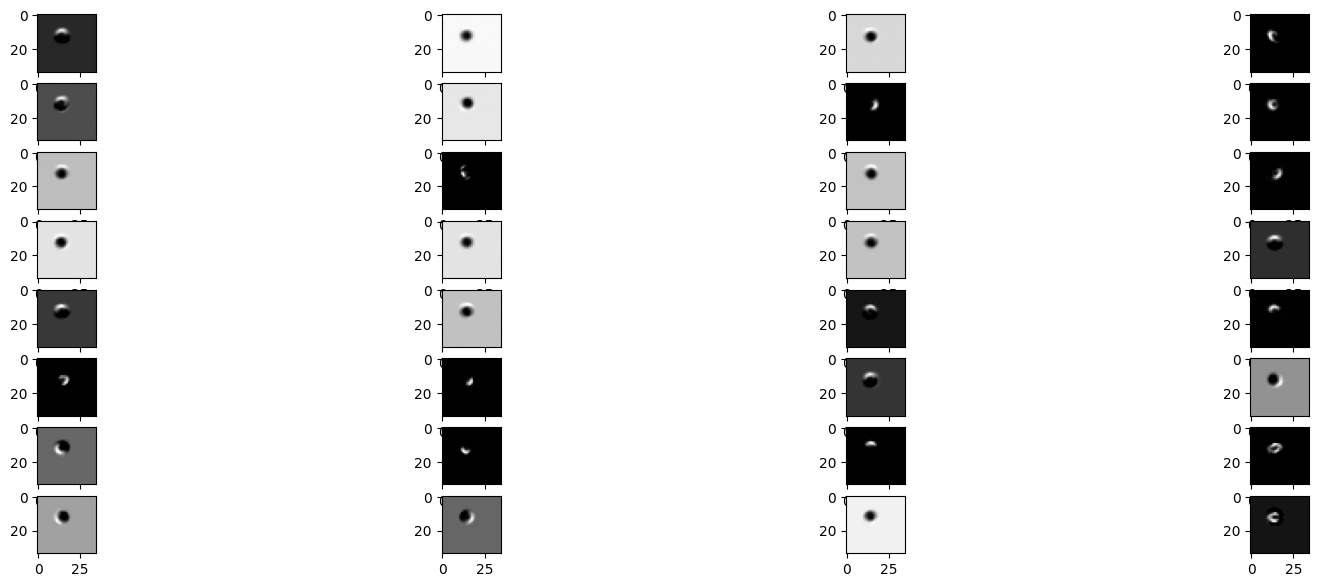

--- Observing the effect of the convolutional layer number 4... ---

64 kernels were applied and here are all the activations of this Conv2D Layer:


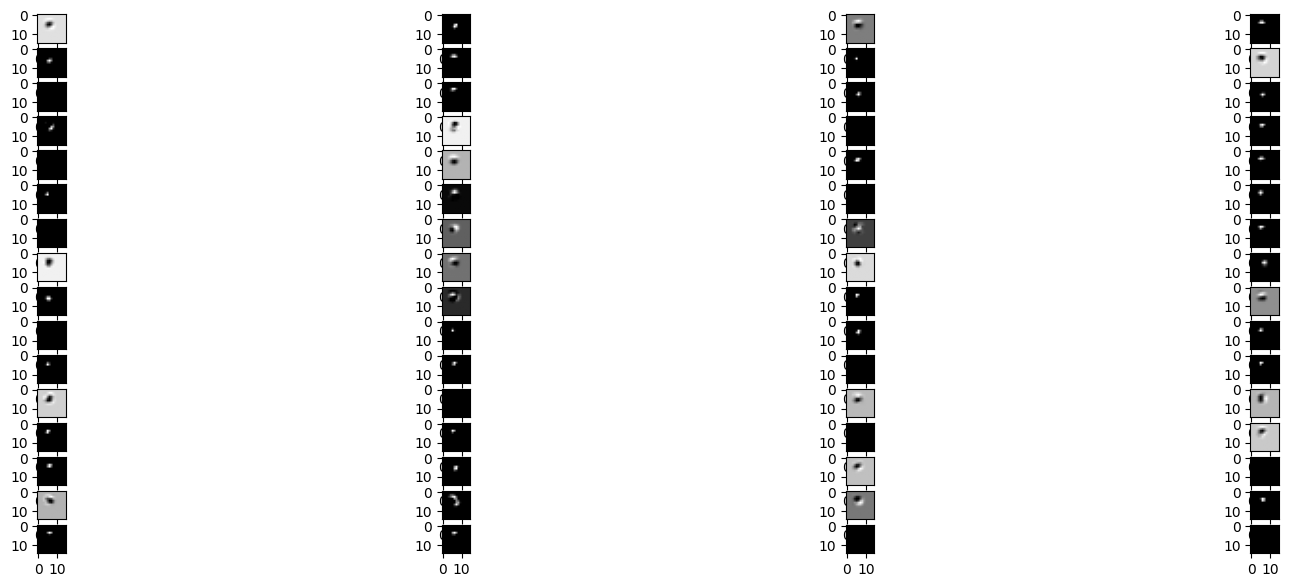

--- Observing the effect of the convolutional layer number 6... ---

64 kernels were applied and here are all the activations of this Conv2D Layer:


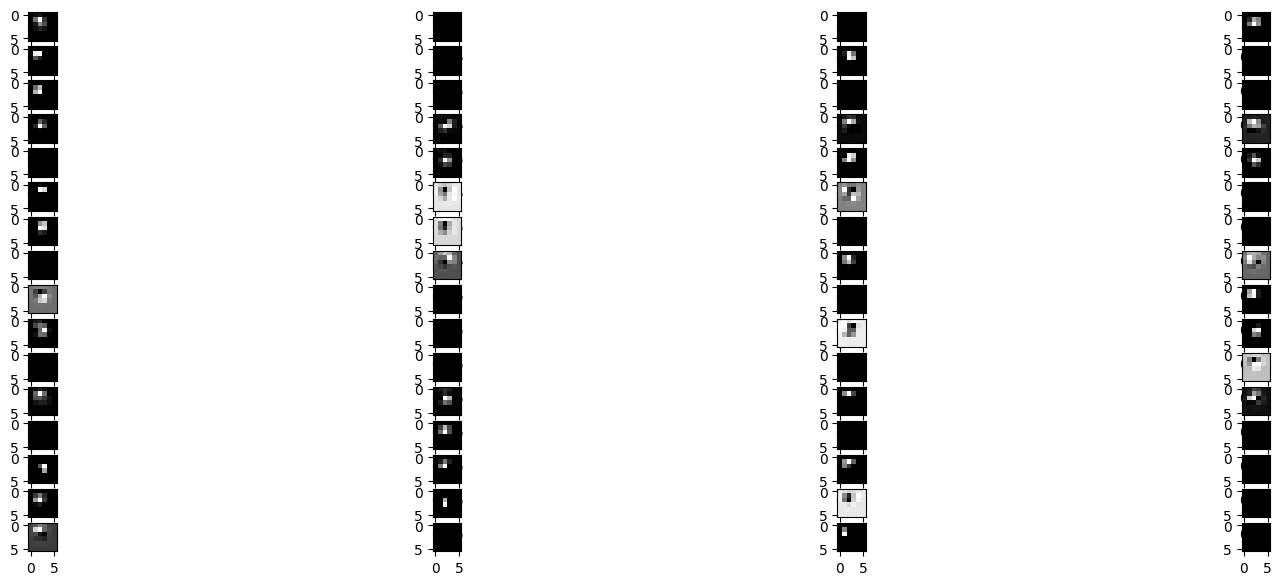

In [ ]:
# Selecting a random circle
image_number = np.random.choice(np.where(y == 0)[0])

for layer_number in [0,2,4,6]:

    print(f"--- Observing the effect of the convolutional layer number {layer_number}... ---")
    print("")

    temp_number_kernels = model.layers[layer_number].weights[0].shape[-1]
    print(f"{temp_number_kernels} kernels were applied and here are all the activations of this Conv2D Layer:")

    fig, axes = plt.subplots(int(temp_number_kernels/4),4, figsize=(20,7))


    for ax, kernel_number in zip(axes.flat,range(temp_number_kernels)):
        activation = activations[layer_number][image_number][:, :, kernel_number]
        ax.imshow(activation, cmap="gray")

    plt.show()


# 3 - CIFAR10 Classification Problem

## (1) Loading the CIFAR10 Dataset

In [ ]:
(images_train, labels_train), (images_test, labels_test) = datasets.cifar10.load_data()

labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']

print(images_train.shape, images_test.shape)
unique, counts = np.unique(labels_train, return_counts=True)
dict(zip(unique, counts))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(50000, 32, 32, 3) (10000, 32, 32, 3)


{np.uint8(0): np.int64(5000),
 np.uint8(1): np.int64(5000),
 np.uint8(2): np.int64(5000),
 np.uint8(3): np.int64(5000),
 np.uint8(4): np.int64(5000),
 np.uint8(5): np.int64(5000),
 np.uint8(6): np.int64(5000),
 np.uint8(7): np.int64(5000),
 np.uint8(8): np.int64(5000),
 np.uint8(9): np.int64(5000)}

### (1.1) Working on a smaller dataset

In [ ]:
# Considering only 1/10th of the 50_000 images
reduction_factor = 10

# Choosing the random indices of small train set and small test set
idx_train =  np.random.choice(len(images_train), round(len(images_train)/reduction_factor), replace=False)
idx_test =  np.random.choice(len(images_test), round(len(images_test)/reduction_factor), replace=False)

# Collecting the two subsamples images_train_small and images_test_small from images_train and images_test
images_train_small = images_train[idx_train]
images_test_small = images_test[idx_test]
# and their corresponding labels
labels_train_small = labels_train[idx_train]
labels_test_small = labels_test[idx_test]

print("------------------ Before -----------------")
print(images_train.shape, images_test.shape)

print("")

print("--- After applying the reduction factor ---")
print(images_train_small.shape, images_test_small.shape)

print("")
print("-"*43)

unique, counts = np.unique(labels_train_small, return_counts=True)
dict(zip(unique, counts))

------------------ Before -----------------
(50000, 32, 32, 3) (10000, 32, 32, 3)

--- After applying the reduction factor ---
(5000, 32, 32, 3) (1000, 32, 32, 3)

-------------------------------------------


{np.uint8(0): np.int64(498),
 np.uint8(1): np.int64(485),
 np.uint8(2): np.int64(508),
 np.uint8(3): np.int64(485),
 np.uint8(4): np.int64(533),
 np.uint8(5): np.int64(516),
 np.uint8(6): np.int64(498),
 np.uint8(7): np.int64(499),
 np.uint8(8): np.int64(503),
 np.uint8(9): np.int64(475)}

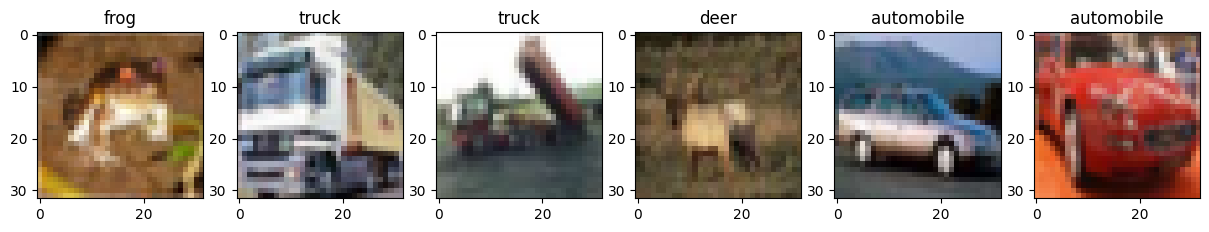

In [ ]:
# Let's plot few images to see what they look like
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
for i in range(6):
    plt.subplot(1,6, i+1)
    img = images_train[i]
    label = labels_train[i][0]
    plt.imshow(img)
    plt.title(labels[label])

### (1.2) Image preprocessing

In [ ]:
# Normalizing pixels' intensities
X_train = images_train / 255.
X_train_small = images_train_small / 255.
X_test = images_test / 255.
X_test_small = images_test_small / 255.

# Encoding the labels
y_train = to_categorical(labels_train, 10)
y_train_small = to_categorical(labels_train_small, 10)
y_test = to_categorical(labels_test, 10)
y_test_small = to_categorical(labels_test_small, 10)

In [ ]:
X_train_small.shape

(5000, 32, 32, 3)

## (2) Iterate in your CNN architecture using your small training set

In [ ]:
def init_compile_model():
  model = Sequential()
  model.add(Input(shape=(32, 32, 3)))

  model.add(layers.Conv2D(16, (4, 4), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))

  model.add(layers.Conv2D(64, (2, 2), activation='relu'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(10, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model = init_compile_model()
model.summary()


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 29, 29, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 5, 5, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,360 (63.91 KB)

 Trainable params: 16,360 (63.91 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train_small, y_train_small, validation_split=0.3, batch_size=16, epochs=50, callbacks=[es], verbose=1)

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.1263 - loss: 2.2766 - val_accuracy: 0.2040 - val_loss: 2.1407
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2007 - loss: 2.1165 - val_accuracy: 0.2433 - val_loss: 2.0542
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2406 - loss: 2.0128 - val_accuracy: 0.2673 - val_loss: 1.9524
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2619 - loss: 1.9141 - val_accuracy: 0.2800 - val_loss: 1.9102
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3059 - loss: 1.8366 - val_accuracy: 0.3087 - val_loss: 1.8546
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3109 - loss: 1.8115 - val_accuracy: 0.3147 - val_loss: 1.8457
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3339 - loss: 1.7741 - val_accuracy: 0.3033 - val_loss: 1.8864
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3396 - loss: 1.7471 - val_accuracy: 0

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

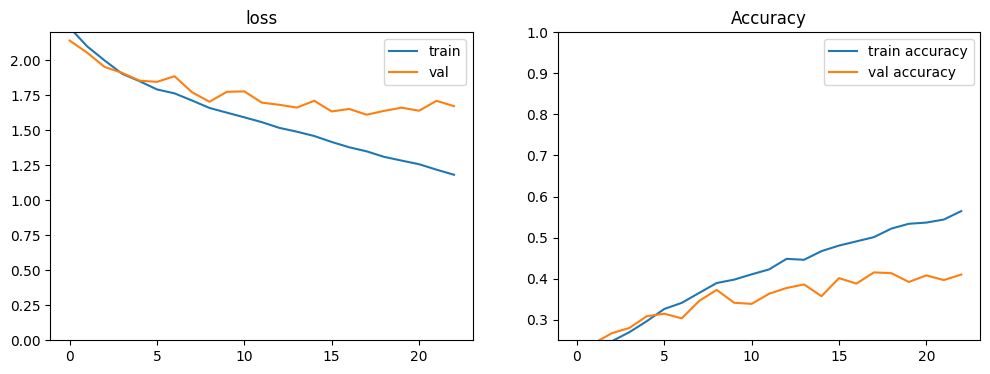

In [ ]:
plot_history(history)
plt.show()

In [ ]:
def init_compile_model():
  model = Sequential()
  model.add(Input(shape=(32, 32, 3)))

  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))

  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))

  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(64, (2, 2), activation='relu', padding='same'))
  model.add(layers.Dropout(0.3))
  model.add(layers.MaxPool2D(pool_size=(2, 2)))

  model.add(layers.Flatten())

  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10, activation='softmax'))

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

model = init_compile_model()
model.summary()


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_59 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 8, 8, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 100)            │       102,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,854 (456.46 KB)

 Trainable params: 116,854 (456.46 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(patience=5, verbose=2, restore_best_weights=True)

history_small = model.fit(X_train_small, y_train_small, validation_split=0.3, batch_size=64, epochs=100, callbacks=[es], verbose=1)

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.1179 - loss: 2.2775 - val_accuracy: 0.2427 - val_loss: 2.1606
Epoch 2/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2142 - loss: 2.0867 - val_accuracy: 0.2833 - val_loss: 2.0500
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2332 - loss: 2.0330 - val_accuracy: 0.3427 - val_loss: 1.8915
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3020 - loss: 1.9005 - val_accuracy: 0.3727 - val_loss: 1.8566
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3552 - loss: 1.7916 - val_accuracy: 0.3907 - val_loss: 1.7664
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3634 - loss: 1.7349 - val_accuracy: 0.4207 - val_loss: 1.6754
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3755 - loss: 1.6974 - val_accuracy: 0.4333 - val_loss: 1.6445
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4192 - loss: 1.6414 - val_accuracy: 0.4127 

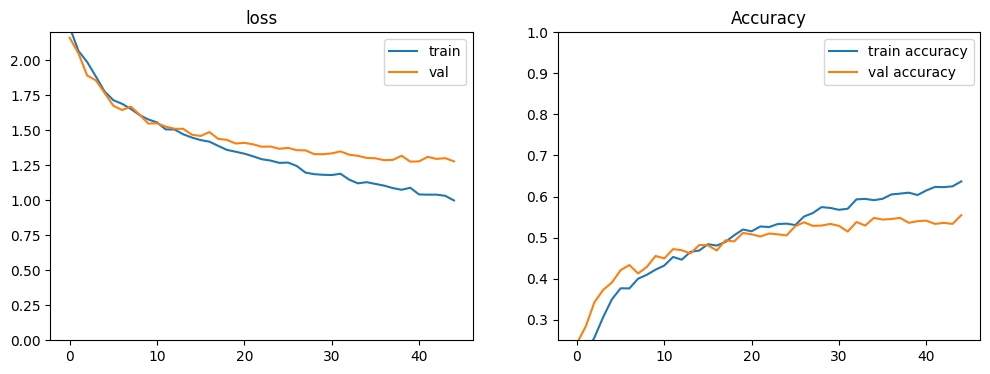

In [ ]:
plot_history(history_small)
plt.show()

In [ ]:
res = model.evaluate(X_test_small, y_test_small, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 56.2% compared to a chance level of 10.0%


## (3) Increase the size of your training data

In [ ]:
model = init_compile_model()
es = EarlyStopping(patience=5, verbose=2, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_split=0.3, batch_size=64, epochs=100, callbacks=[es], verbose=1)

Epoch 1/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.2455 - loss: 2.0163 - val_accuracy: 0.4311 - val_loss: 1.6443
Epoch 2/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4248 - loss: 1.5714 - val_accuracy: 0.4776 - val_loss: 1.5078
Epoch 3/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4803 - loss: 1.4272 - val_accuracy: 0.5392 - val_loss: 1.3277
Epoch 4/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5189 - loss: 1.3475 - val_accuracy: 0.5777 - val_loss: 1.2426
Epoch 5/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5376 - loss: 1.2820 - val_accuracy: 0.5949 - val_loss: 1.1920
Epoch 6/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5591 - loss: 1.2324 - val_accuracy: 0.6125 - val_loss: 1.1382
Epoch 7/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5741 - loss: 1.2023 - val_accuracy: 0.6011 - val_loss: 1.1789
Epoch 8/100
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5903 - loss: 1.1562 - val_ac

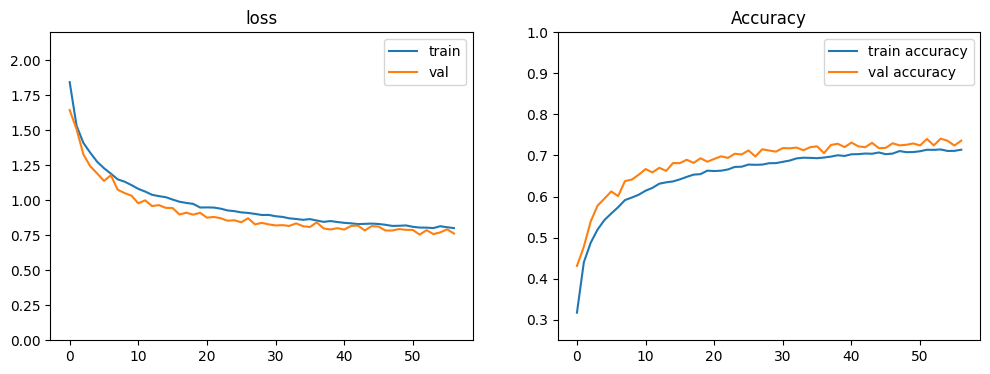

In [ ]:
plot_history(history)
plt.show()

In [ ]:
res = model.evaluate(X_test, y_test, verbose = 0)

print(f'The accuracy is {res[1]*100:.3f}% compared to a chance level of {1./len(labels)*100}%')

The accuracy is 73.450% compared to a chance level of 10.0%


## (4) Data augmentation

In [ ]:
datagen = ImageDataGenerator(
  featurewise_center = False,
  featurewise_std_normalization = False,
  rotation_range = 10,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  horizontal_flip = True,
  zoom_range = (0.8, 1.2),
)

datagen.fit(X_train)
datagen

In [ ]:
X_augmented_iterator = datagen.flow(X_train, shuffle=False, batch_size=1)
X_augmented_iterator

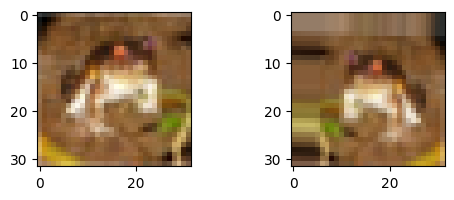

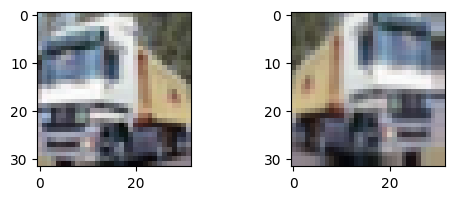

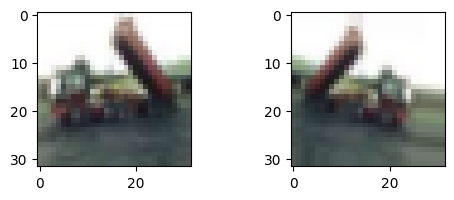

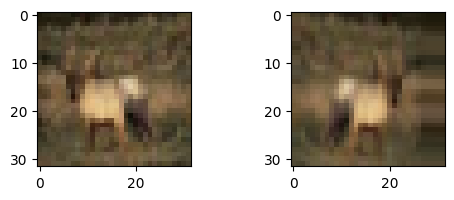

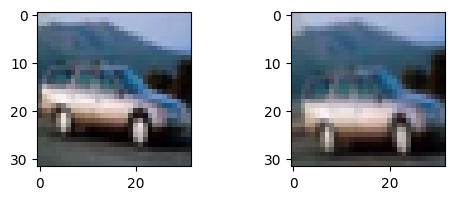

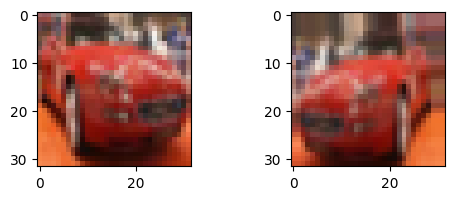

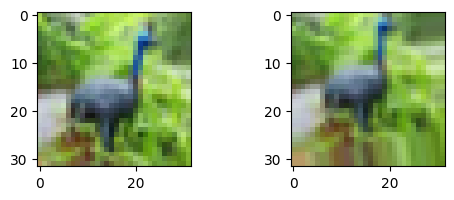

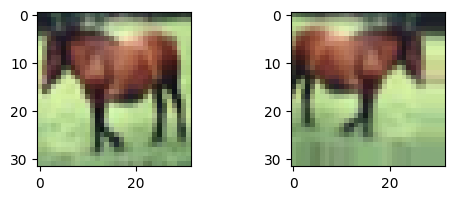

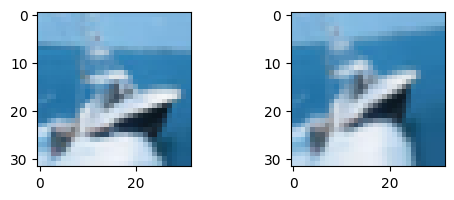

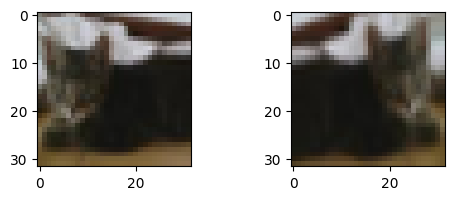

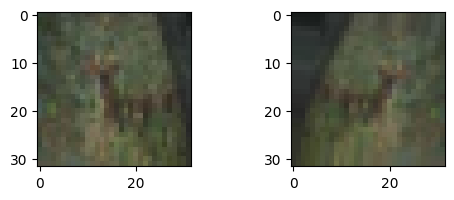

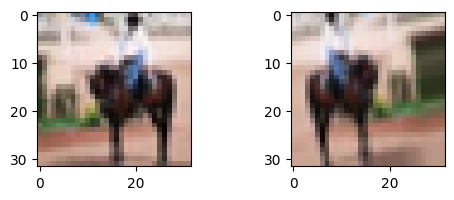

In [ ]:
for i, (raw_image, augmented_image) in enumerate(zip(X_train, X_augmented_iterator)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
    ax1.imshow(raw_image)
    ax2.imshow(augmented_image[0])
    plt.show()

    if i > 10:
        break

In [ ]:
model_aug = init_compile_model()

# The data generator
X_tr = X_train[:40000]
y_tr = y_train[:40000]
X_val = X_train[40000:]
y_val = y_train[40000:]
train_flow = datagen.flow(X_tr, y_tr, batch_size = 64)

# The early stopping criterion
es = EarlyStopping(patience = 3)

# The fit
history_aug = model_aug.fit(train_flow,
                        epochs = 50,
                        callbacks = [es],
                        validation_data = (X_val, y_val))

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.2480 - loss: 2.0304 - val_accuracy: 0.4451 - val_loss: 1.6056
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.3930 - loss: 1.6565 - val_accuracy: 0.4929 - val_loss: 1.4422
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.4394 - loss: 1.5435 - val_accuracy: 0.5293 - val_loss: 1.3808
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.4612 - loss: 1.4857 - val_accuracy: 0.5208 - val_loss: 1.3468
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.4806 - loss: 1.4410 - val_accuracy: 0.5731 - val_loss: 1.2277
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.5007 - loss: 1.3855 - val_accuracy: 0.5793 - val_loss: 1.1987
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5100 - loss: 1.3573 - val_accuracy: 0.5862 - val_loss: 1.1676
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.5161 - loss: 1.3403 - val_accurac

In [ ]:
axs = plot_history(history_aug, exp_name = 'data_augmentation')
plot_history(history ,axs = axs, exp_name='baseline')
plt.show()

In [ ]:
res_1 = model.evaluate(X_test, y_test, verbose = 0)

res_2 = model_aug.evaluate(X_test, y_test, verbose = 1)

print(f'Accuracy without data augmentation {res_1[1]*100:.2f}%')
print(f'Accuracy with data augmentation {res_2[1]*100:.2f}%')

# 4 - Transfer Learning

## (3) Introduction to VGG16 - Data loading & Preprocessing

In [3]:
!wget https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip
!unzip -q -n flowers-dataset.zip

--2025-10-10 12:50:01--  https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 3.5.65.212, 52.218.121.97, 52.218.112.90, ...
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|3.5.65.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104983809 (100M) [application/zip]
Saving to: ‘flowers-dataset.zip’

flowers-dataset.zip 100%[===================>] 100.12M  18.1MB/s    in 6.4s    

2025-10-10 12:50:08 (15.7 MB/s) - ‘flowers-dataset.zip’ saved [104983809/104983809]



In [5]:
!pwd

/content


In [6]:
!ls

flowers  flowers-dataset.zip  sample_data


In [17]:
def load_flowers_data():
  data_path = 'flowers/'

  classes = {'daisy':0, 'dandelion':1, 'rose':2}
  imgs = []
  labels = []

  for (cl, i) in classes.items():
    images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('jpg')>0]
    for img in tqdm(images_path[:300]):
      path = os.path.join(data_path, cl, img)
      if os.path.exists(path):
        image = Image.open(path)
        image = image.resize((256, 256))
        imgs.append(np.array(image))
        labels.append(i)

  X = np.array(imgs)
  num_classes = len(set(labels))
  y = to_categorical(labels, num_classes)

  # Finally we shuffle:
  p = np.random.permutation(len(X))
  X, y = X[p], y[p]

  first_split = int(len(imgs) /6.)
  second_split = first_split + int(len(imgs) * 0.2)
  X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
  y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

  return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [19]:
# CALL load_flowers_data
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data()

100%|██████████| 299/299 [00:00<00:00, 327.58it/s]


In [20]:
print(X_train.shape, X_val.shape, X_test.shape)

(571, 256, 256, 3) (179, 256, 256, 3) (149, 256, 256, 3)


In [21]:
y_train

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.]])

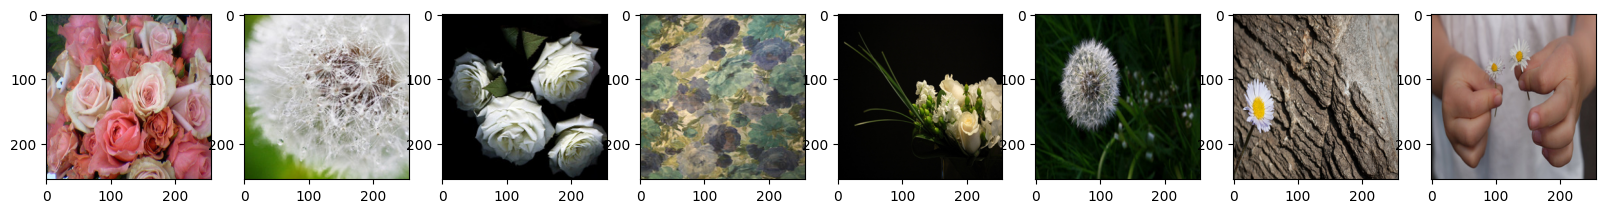

In [25]:
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])

## (4) A CNN architecture

In [35]:
def load_own_model():
  model = Sequential()
  model.add(Input(shape=(256, 256, 3)))

  model.add(layers.Rescaling(1./255))

  model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
  model.add(layers.MaxPool2D(3))

  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(32, kernel_size=8, activation='relu'))
  model.add(layers.MaxPool2D(3))

  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(32, kernel_size=6, activation='relu'))
  model.add(layers.MaxPool2D(3))

  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(64, kernel_size=4, activation='relu'))
  model.add(layers.MaxPool2D(3))

  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(3, activation='softmax'))

  opt = optimizers.Adam(learning_rate=1e-4)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

model_homemade = load_own_model()
model_homemade.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 247, 247, 16)   │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 82, 82, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 82, 82, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 3, 3, 64)       │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │         6,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,147 (445.89 KB)

 Trainable params: 114,147 (445.89 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)
history = model_homemade.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=100, callbacks=[es])

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.3382 - loss: 1.1029 - val_accuracy: 0.3799 - val_loss: 1.0922
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.3375 - loss: 1.0898 - val_accuracy: 0.4469 - val_loss: 1.0878
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3592 - loss: 1.0847 - val_accuracy: 0.4525 - val_loss: 1.0792
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3701 - loss: 1.0638 - val_accuracy: 0.5419 - val_loss: 1.0386
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5120 - loss: 1.0141 - val_accuracy: 0.6648 - val_loss: 0.9122
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5353 - loss: 0.9304 - val_accuracy: 0.5810 - val_loss: 0.8606
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5380 - loss: 0.8811 - val_accuracy: 0.6927 - val_loss: 0.8084
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6082 - loss: 0.8624 - val_accuracy: 

In [37]:
res = model_homemade.evaluate(X_test, y_test)
res

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.6435 - loss: 0.8600


[0.7979891896247864, 0.6778523325920105]

In [38]:
test_accuracy = res[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")

test_accuracy = 68.0 %


## (5) Using a pre-trained CNN = Transfer Learning

In [43]:
def load_vgg16_model():
  model = VGG16(
      include_top=False,
      weights='imagenet',
      input_shape=X_train[0].shape
  )

  return model

model = load_vgg16_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Deactivating the training of the VGG16 parameters
def set_nontrainable_layers(model):
  model.trainable = False

  return model

model = set_nontrainable_layers(model)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [47]:
def add_last_layers(base_model):
  flatten_layer = layers.Flatten()
  dense_layer = layers.Dense(500, activation='relu')
  prediction_layer = layers.Dense(3, activation='softmax')

  model = Sequential([
      base_model,
      flatten_layer,
      dense_layer,
      prediction_layer
  ])

  return model

model = load_vgg16_model()
model = set_nontrainable_layers(model)
model = add_last_layers(model)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 500)            │    16,384,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,100,691 (118.64 MB)

 Trainable params: 16,386,003 (62.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [49]:
def build_model():
  model = load_vgg16_model()
  model = set_nontrainable_layers(model)
  model = add_last_layers(model)

  opt = optimizers.Adam(learning_rate=1e-4)
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

  return model

model = build_model()
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 500)            │    16,384,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │         1,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,100,691 (118.64 MB)

 Trainable params: 16,386,003 (62.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [51]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [56]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=50, callbacks=[es])

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 607ms/step - accuracy: 0.7399 - loss: 3.3459 - val_accuracy: 0.8101 - val_loss: 2.7700
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9651 - loss: 0.7509 - val_accuracy: 0.9050 - val_loss: 1.3293
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9893 - loss: 0.0126 - val_accuracy: 0.9162 - val_loss: 1.5080
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 3.2732e-05 - val_accuracy: 0.9162 - val_loss: 1.4719
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 2.1864e-05 - val_accuracy: 0.9162 - val_loss: 1.4766
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.6552e-06 - val_accuracy: 0.9162 - val_loss: 1.4769
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 3.5992e-06 - val_accuracy: 0.9162 - val_loss: 1.4769
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 4.6000e-

In [58]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

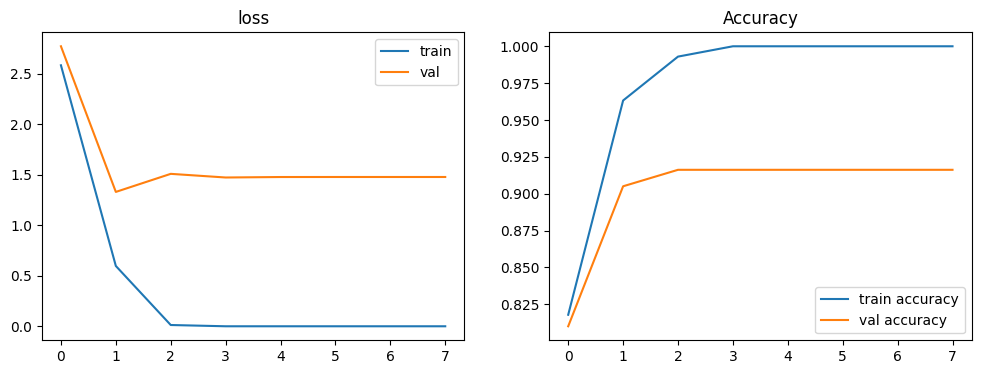

In [59]:
plot_history(history)

In [60]:
res_vgg = model.evaluate(X_test, y_test)

test_accuracy_vgg = res_vgg[-1]


print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.8864 - loss: 1.6007
test_accuracy_vgg = 89.0 %
test_accuracy = 68.0 %
Chance level: 33.3%


## (6) Improve the model

### (6.1) Data augmentation

In [61]:
datagen = ImageDataGenerator(
  featurewise_center=False,
  featurewise_std_normalization=False,
  rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  horizontal_flip=True,
  brightness_range=(0.5, 1.),
  zoom_range=(0.3, 1.5)
)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

model_data_aug = build_model()

train_flow = datagen.flow(X_train, y_train, batch_size=16)
val_flow = datagen.flow(X_val, y_val, batch_size=16)

es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

history_data_aug = model_data_aug.fit(train_flow,
                                      validation_data=val_flow,
                                      epochs=50,
                                      callbacks=[es])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 21s 514ms/step - accuracy: 0.6498 - loss: 3.5264 - val_accuracy: 0.8492 - val_loss: 1.6694
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 18s 488ms/step - accuracy: 0.8630 - loss: 1.6920 - val_accuracy: 0.7709 - val_loss: 1.6364
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 533ms/step - accuracy: 0.8705 - loss: 1.3594 - val_accuracy: 0.8156 - val_loss: 1.3733
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 19s 535ms/step - accuracy: 0.8967 - loss: 0.8517 - val_accuracy: 0.8045 - val_loss: 1.8891
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 23s 630ms/step - accuracy: 0.8740 - loss: 1.0352 - val_accuracy: 0.8212 - val_loss: 1.7967
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 463ms/step - accuracy: 0.8889 - loss: 0.7380 - val_accuracy: 0.8101 - val_loss: 1.5078
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

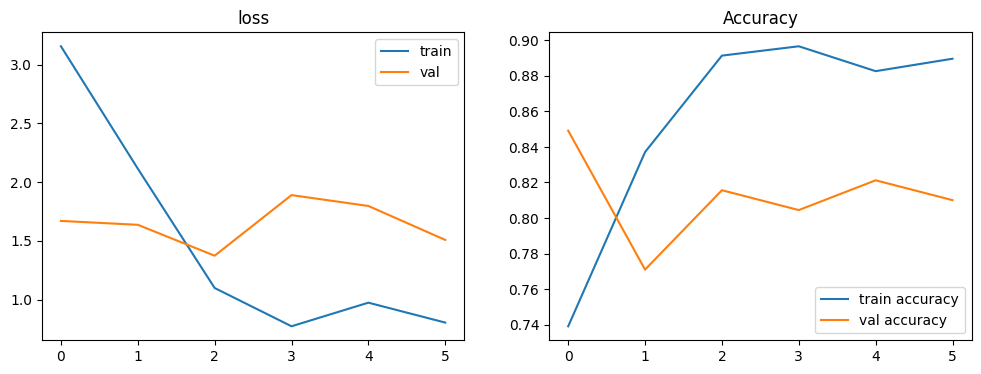

In [62]:
plot_history(history_data_aug)

In [63]:
res_aug = model_data_aug.evaluate(X_test, y_test)

test_accuracy_aug = res_aug[-1]

print(f"test_accuracy_aug = {round(test_accuracy_aug,2)*100} %")

print(f"test_accuracy_vgg = {round(test_accuracy_vgg,2)*100} %")

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.8987 - loss: 1.0088
test_accuracy_aug = 90.0 %
test_accuracy_vgg = 89.0 %
test_accuracy = 68.0 %


# 5 - Autoencoders

## (0) The MNIST dataset

In [65]:
(images_train, labels_train), (images_test, labels_test) = datasets.mnist.load_data()
print(images_train.shape)
print(images_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [66]:
# Add a channels for the colors and normalize data
X_train = images_train.reshape((60000, 28, 28, 1)) / 255.
X_test = images_test.reshape((10000, 28, 28, 1)) / 255.

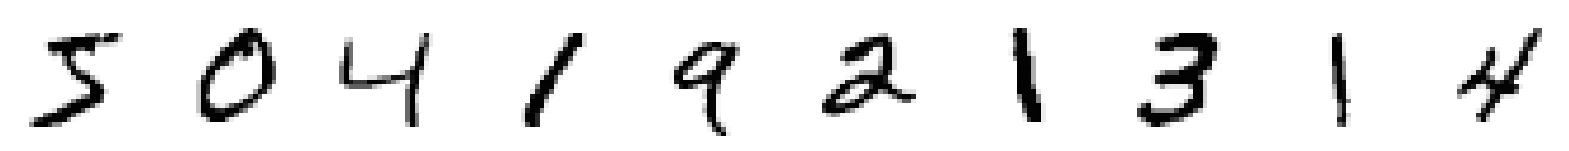

In [67]:
f, axs = plt.subplots(1, 10, figsize=(20, 4))
for i, ax in enumerate(axs):
    ax.axis('off')
    ax.imshow(X_train[i].reshape(28, 28), cmap='Greys')

plt.show()

## (1) Encoder

In [86]:
def build_encoder(latent_dimension):
  encoder = Sequential()
  encoder.add(Input(shape=(28, 28, 1)))

  encoder.add(layers.Conv2D(8, (2,2), activation='relu'))
  encoder.add(layers.MaxPooling2D(2))

  encoder.add(layers.Conv2D(16, (2, 2), activation='relu'))
  encoder.add(layers.MaxPooling2D(2))

  encoder.add(layers.Conv2D(32, (2, 2), activation='relu'))
  encoder.add(layers.MaxPooling2D(2))

  encoder.add(layers.Flatten())
  encoder.add(layers.Dense(latent_dimension, activation='tanh'))

  return encoder

encoder = build_encoder(2)
encoder.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 27, 27, 8)      │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 13, 13, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 5, 5, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,906 (11.35 KB)

 Trainable params: 2,906 (11.35 KB)

 Non-trainable params: 0 (0.00 B)

## (2) Decoder

In [87]:
def build_decoder(latent_dimension):
  decoder = Sequential()
  decoder.add(Input(shape=(latent_dimension,)))

  decoder.add(layers.Dense(7*7*8, activation='tanh'))

  decoder.add(layers.Reshape((7, 7, 8)))

  decoder.add(layers.Conv2DTranspose(8, (2, 2), strides=2, padding='same', activation='relu'))

  decoder.add(layers.Conv2DTranspose(1, (2, 2), strides=2, padding='same', activation='relu'))

  return decoder

decoder = build_decoder(2)
decoder.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 392)            │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 14, 14, 8)      │           264 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 28, 28, 1)      │            33 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,473 (5.75 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 0 (0.00 B)

## (3) Auto-Encoder

In [88]:
def build_autoencoder(encoder, decoder):
  inp = Input((28, 28, 1))
  encoded = encoder(inp)
  decoded = decoder(encoded)
  autoencoder = Model(inp, decoded)
  return autoencoder

autoencoder = build_autoencoder(encoder, decoder)
autoencoder.summary()

Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_14 (Sequential)      │ (None, 2)              │         2,906 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (None, 28, 28, 1)      │         1,473 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379 (17.11 KB)

 Trainable params: 4,379 (17.11 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
def compile_autoencoder(autoencoder):
  autoencoder.compile(loss='mse', optimizer='adam')

compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs = 20, batch_size = 32)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0686
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0539
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0526
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0521
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0519
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0517
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0515
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0512
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0510
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0509
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0508
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0505
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0505
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0503
Epoch 15/20
1875/1875 ━━━━━

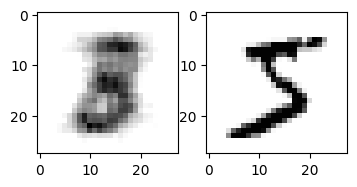

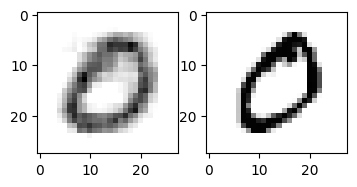

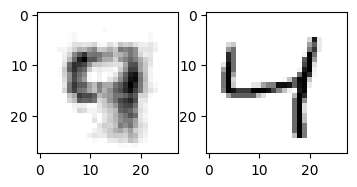

In [90]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=100)# you can now display an image to see it is reconstructed well

for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(prediction[i].reshape(28,28), cmap = 'Greys')
    ax2.imshow(X_train[i].reshape(28,28), cmap = 'Greys')
    plt.show()

In [91]:
X_encoded = encoder.predict(X_train, verbose=2)

1875/1875 - 3s - 2ms/step


In [92]:
labels_train[:300]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
       0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2,
       9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4,
       5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9,
       9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5,
       9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8,
       3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5,
       2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6,
       3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7,
       9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9,
       6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6], d

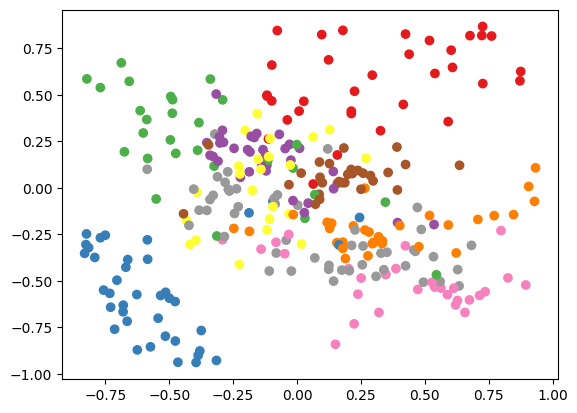

In [93]:
plt.scatter(x = X_encoded[:300, 0],
            y = X_encoded[:300, 1],
            c = labels_train[:300],
            cmap = 'Set1')
plt.show()

## (4) Image generation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


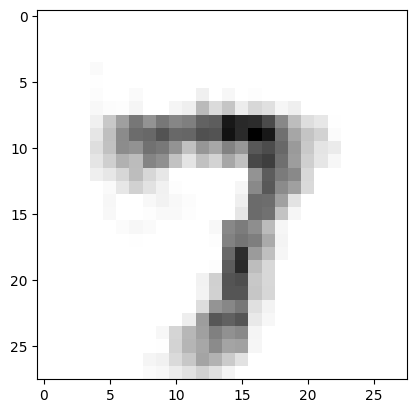

In [97]:
latent_coords = np.array([[0.75, -0.75]])
generated_img = decoder.predict(latent_coords)
plt.imshow(generated_img.reshape(28,28), cmap='Greys')
plt.show()

## (5) Image denoising

In [98]:
noise_factor = 0.5

X_train_noisy = X_train + noise_factor * np.random.normal(0., 1., size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(0., 1., size=X_test.shape)

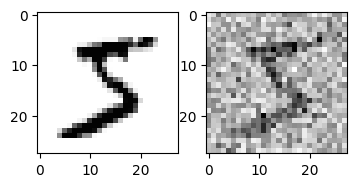

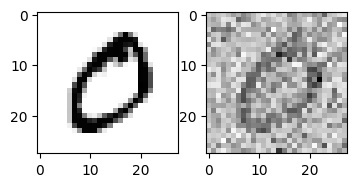

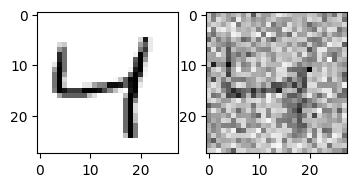

In [99]:
for i in range(3):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
  ax1.imshow(X_train[i].reshape(28,28), cmap='Greys')
  ax2.imshow(X_train_noisy[i].reshape(28,28), cmap='Greys')
  plt.show()

In [101]:
encoder = build_encoder(2)
decoder = build_decoder(2)
autoencoder = build_autoencoder(encoder, decoder)
compile_autoencoder(autoencoder)
history_denoising = autoencoder.fit(X_train_noisy, X_train_noisy, epochs=20, batch_size=32)

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.3187
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3054
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3044
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3033
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3028
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3023
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3019
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3019
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3017
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3016
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3015
Epoch 12/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3012
Epoch 13/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3015
Epoch 14/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.3011
Epoch 15/20
1875/1875 ━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


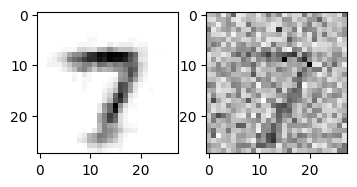

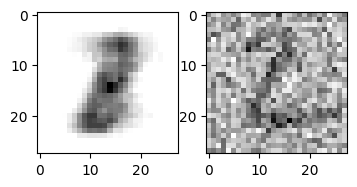

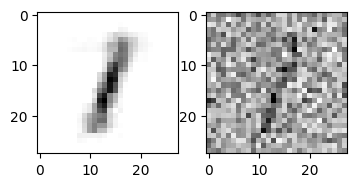

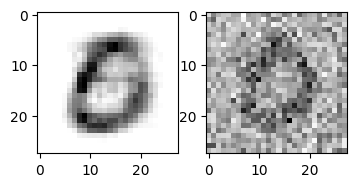

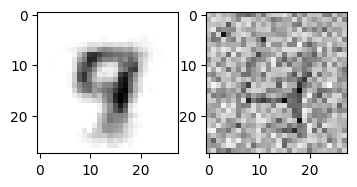

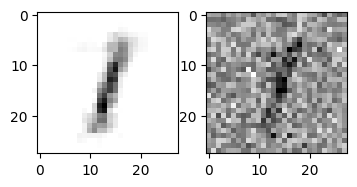

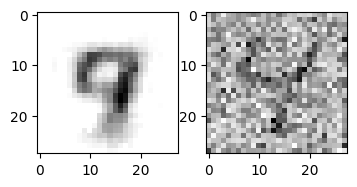

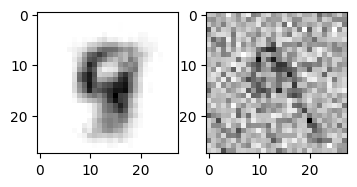

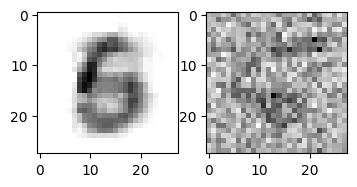

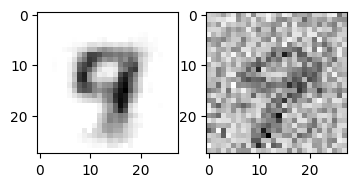

In [102]:
prediction = autoencoder.predict(X_test_noisy, verbose=1)

for i in range(10):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(4,2))
    ax1.imshow(prediction[i].reshape(28,28), cmap = 'Greys')
    ax2.imshow(X_test_noisy[i].reshape(28,28), cmap = 'Greys')
    plt.show()

In [ ]:
latent_dimensions = list(range(2,20,3))

test_errors = []
for latent_dimension in latent_dimensions:
  print(" ")
  print("-"*80)
  print(f"Running the autoencoder with latent_dimension = {latent_dimension}")
  print("-"*80)

  encoder = build_encoder(latent_dimension=latent_dimension)
  decoder = build_decoder(latent_dimension=latent_dimension)
  autoencoder = build_autoencoder(encoder, decoder)

  compile_autoencoder(autoencoder)
  autoencoder.fit(X_train, X_train, epochs=20, batch_size=32)
  error = autoencoder.evaluate(X_test, X_test)
  test_errors.append(error)

In [ ]:
with plt.style.context('fast'):
    # figsize
    plt.figure(figsize=(10,6))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(latent_dimensions,
            test_errors,
            color='black',
            linestyle='dashed',
            marker='o',
            markerfacecolor='#947FFF',
            markersize=10)
    # more
    ax.set_title('MSE Test Error vs. $Latent$ $Dimensions$', fontsize = 18)
    ax.set_xlabel('Latent Dimension', fontsize = 14)
    ax.set_ylabel('MSE Score', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    # focusing
    ax.scatter(8,test_errors[2],c='#00ad8b',s=700)

    # annotate
    ax.annotate("Elbow Method ?",
               xy=(8,test_errors[2]),
                xytext=(8+0.25,test_errors[2]+0.0025),
                arrowprops=dict(arrowstyle='-|>',
                                fc="k",
                                ec="k",
                                lw=2),
                bbox=dict(pad=5, facecolor="none", edgecolor="none")
               )


    plt.show();